<font size="5">Required Imports</font>

In [ ]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import gc
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.losses import MSE
from sklearn.model_selection  import train_test_split
from tensorflow.keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop,Adam
import keras.backend as K
import tensorflow as tf
from sklearn import preprocessing
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras import regularizers
from tensorflow import keras
import lightgbm as lgb
import matplotlib.cm as cm
from windrose import WindroseAxes


<font size="5">Loading Dataset</font>

In [2]:
building_df = pd.read_csv('building_metadata.csv')
weather_train_df = pd.read_csv('weather_train.csv')
weather_test_df = pd.read_csv('weather_test.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

<font size="5">Data Observation</font>

Building Meta Data

In [3]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


Weather Train

In [4]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


Weather Test

In [5]:
weather_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             277243 non-null  int64  
 1   timestamp           277243 non-null  object 
 2   air_temperature     277139 non-null  float64
 3   cloud_coverage      136795 non-null  float64
 4   dew_temperature     276916 non-null  float64
 5   precip_depth_1_hr   181655 non-null  float64
 6   sea_level_pressure  255978 non-null  float64
 7   wind_direction      264873 non-null  float64
 8   wind_speed          276783 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 19.0+ MB


Train

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


Test

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   row_id       int64 
 1   building_id  int64 
 2   meter        int64 
 3   timestamp    object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB


Reducing Memory Usage 

In [8]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    """
    Reduce memory usage of a pandas DataFrame by downcasting numeric types.
    The methods check for highest value in each column to fall into lowest 
    numeric data type for its represenation and cast to it accordingly.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame to reduce memory usage.
    verbose : bool, default True
        If True, print the memory usage reduction.

    Returns:
    --------
    pd.DataFrame
        DataFrame with reduced memory usage.

    Example:
    --------
    df = pd.read_csv('large_dataset.csv')
    df = reduce_mem_usage(df)
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
      print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_df = reduce_mem_usage(building_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


Max Memory Usage reduced to 0.03 MB from 1.2GB

Merging Dataset & Memory Optimization through Garbage Collector

In [10]:
# Merge 'building_df' onto 'train_df' using the 'building_id' column as the join key
train_df = train_df.merge(building_df, on='building_id', how='left')

# Merge 'building_df' onto 'test_df' using the 'building_id' column as the join key
test_df = test_df.merge(building_df, on='building_id', how='left')

# Merge 'weather_train_df' onto 'train_df' using 'site_id' and 'timestamp' columns as the join keys
train_df = train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

# Merge 'weather_test_df' onto 'test_df' using 'site_id' and 'timestamp' columns as the join keys
test_df = test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

# Delete unnecessary DataFrames to free up memory
del weather_train_df, weather_test_df, building_df

# Call the garbage collector to free up any memory that is no longer being used
gc.collect()


43

Converting timestamp datatype

In [11]:
# String to date time object, for better analysis
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

# Call the garbage collector to free up any memory that is no longer being used
gc.collect();

In [12]:
train_df.head()

building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01            0.0        0   Education   
1            1      0 2016-01-01            0.0        0   Education   
2            2      0 2016-01-01            0.0        0   Education   
3            3      0 2016-01-01            0.0        0   Education   
4            4      0 2016-01-01            0.0        0   Education   

   square_feet  year_built  floor_count  air_temperature  cloud_coverage  \
0         7432      2008.0          NaN             25.0             6.0   
1         2720      2004.0          NaN             25.0             6.0   
2         5376      1991.0          NaN             25.0             6.0   
3        23685      2002.0          NaN             25.0             6.0   
4       116607      1975.0          NaN             25.0             6.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0             20.0                NaN              1019.5             0.0   
1             20.0                NaN              1019.5             0.0   
2             20.0                NaN              1019.5             0.0   
3             20.0                NaN              1019.5             0.0   
4             20.0                NaN              1019.5             0.0   

   wind_speed  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [13]:
test_df.head()

row_id  building_id  meter  timestamp  site_id primary_use  square_feet  \
0       0            0      0 2017-01-01        0   Education         7432   
1       1            1      0 2017-01-01        0   Education         2720   
2       2            2      0 2017-01-01        0   Education         5376   
3       3            3      0 2017-01-01        0   Education        23685   
4       4            4      0 2017-01-01        0   Education       116607   

   year_built  floor_count  air_temperature  cloud_coverage  dew_temperature  \
0      2008.0          NaN        17.796875             4.0        11.703125   
1      2004.0          NaN        17.796875             4.0        11.703125   
2      1991.0          NaN        17.796875             4.0        11.703125   
3      2002.0          NaN        17.796875             4.0        11.703125   
4      1975.0          NaN        17.796875             4.0        11.703125   

   precip_depth_1_hr  sea_level_pressure  wind_direction  wind_speed  
0                NaN              1021.5           100.0    3.599609  
1                NaN              1021.5           100.0    3.599609  
2                NaN              1021.5           100.0    3.599609  
3                NaN              1021.5           100.0    3.599609  
4                NaN              1021.5           100.0    3.599609

# T-1 Exploratory Data Analysis

### Checking the Dataset for NULL values

In [14]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

Total    Percent
floor_count         16709167  82.652772
year_built          12127645  59.990033
cloud_coverage       8825365  43.655131
precip_depth_1_hr    3749023  18.544739
wind_direction       1449048   7.167792
sea_level_pressure   1231669   6.092515
wind_speed            143676   0.710701
dew_temperature       100140   0.495348
air_temperature        96658   0.478124
building_id                0   0.000000
meter                      0   0.000000
timestamp                  0   0.000000
meter_reading              0   0.000000
site_id                    0   0.000000
primary_use                0   0.000000
square_feet                0   0.000000

As we can see that there are plenty of NULL values that will be dealth with later in Pre-Processing (T-2)

#### Checking Coorelations Now

In [15]:
# Find correlations with the target and sort
correlations = train_df.corr()['meter_reading'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 sea_level_pressure   -0.004216
air_temperature      -0.004132
dew_temperature      -0.003330
wind_direction       -0.000078
precip_depth_1_hr     0.000509
cloud_coverage        0.006024
wind_speed            0.006071
building_id           0.008761
site_id               0.011897
meter                 0.017672
square_feet           0.024308
year_built            0.111837
floor_count           0.130224
meter_reading         1.000000
Name: meter_reading, dtype: float64

Most Negative Correlations:
 sea_level_pressure   -0.004216
air_temperature      -0.004132
dew_temperature      -0.003330
wind_direction       -0.000078
precip_depth_1_hr     0.000509
cloud_coverage        0.006024
wind_speed            0.006071
building_id           0.008761
site_id               0.011897
meter                 0.017672
square_feet           0.024308
year_built            0.111837
floor_count           0.130224
meter_reading         1.000000
Name: meter_reading, dtype: float64


Based on the given correlation coefficients, there doesn't seem to be any strong positive or negative correlation between the meter_reading variable and the other variables in the dataset.

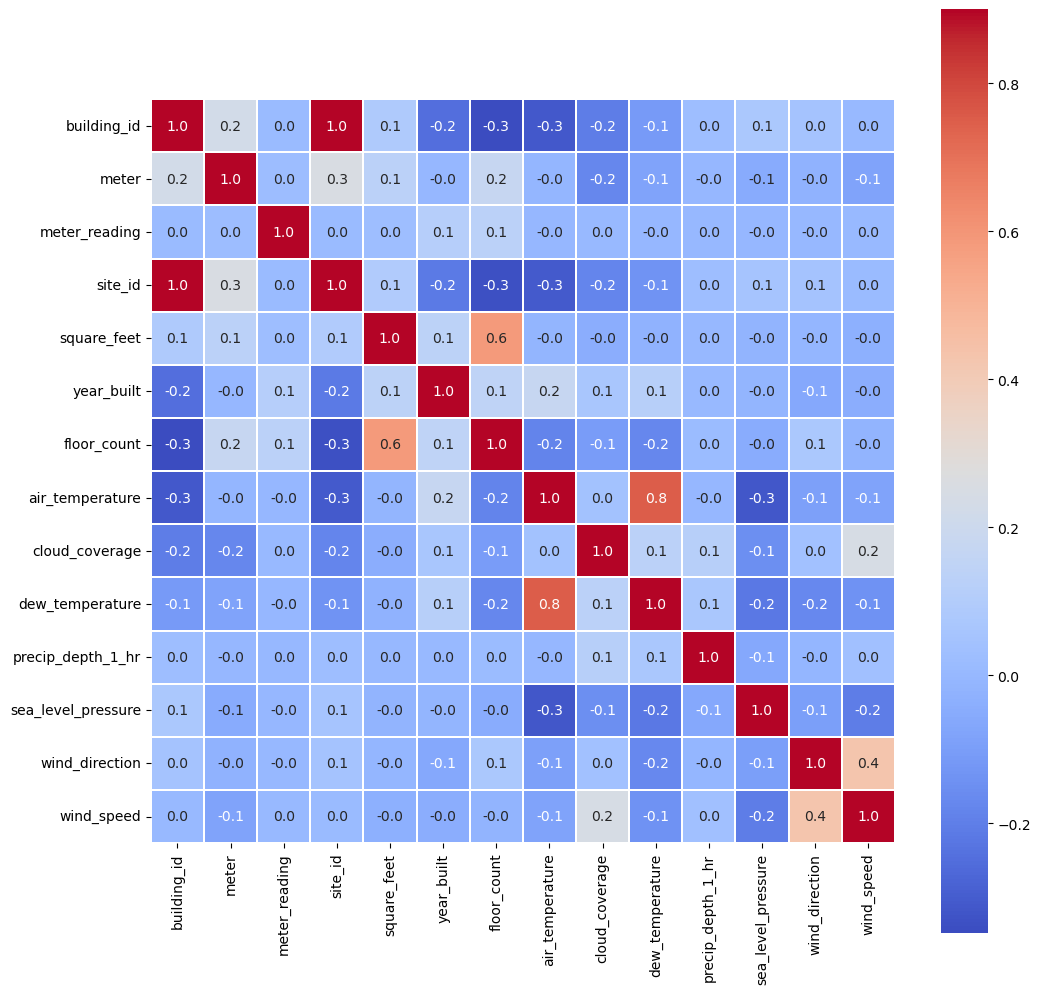

In [16]:
corr_matrix = train_df.corr()

# Plotting Heatmap of the Correlation Matrix
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, vmax=0.9, square=True, annot=True, linewidths=0.3, cmap="coolwarm", fmt=".1f")

# Show plot
plt.show()

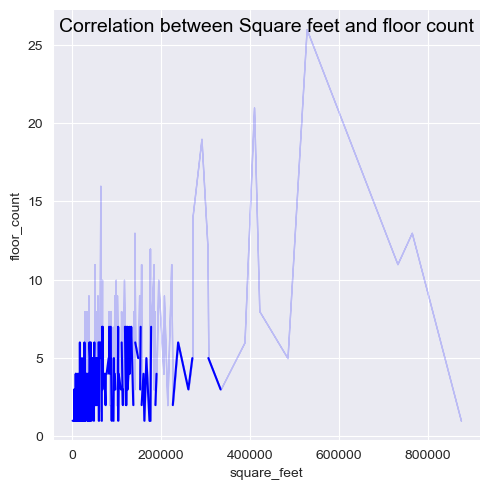

In [17]:
sns.set_style("darkgrid")

# Create the plot
sns.relplot(data=train_df, x='square_feet', y='floor_count', kind="line", color='blue')

# Add a text annotation
plt.annotate("Correlation between Square feet and floor count", xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=14, color='black')

# Show the plot
plt.show()

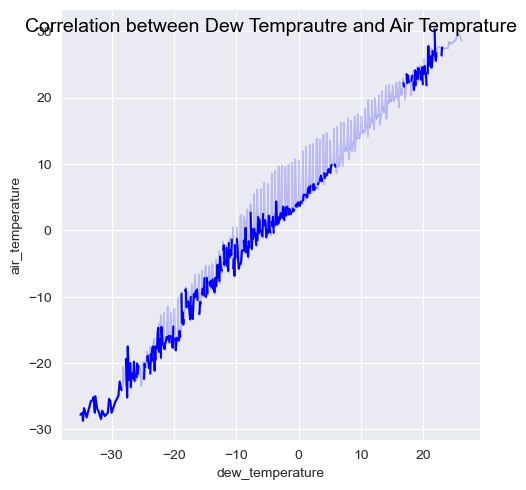

In [18]:
sns.set_style("darkgrid")

# Create the plot
sns.relplot(data=train_df, x='dew_temperature', y='air_temperature', kind="line", color='blue')

# Add a text annotation
plt.annotate("Correlation between Dew Temprautre and Air Temprature", xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=14, color='black')

# Show the plot
plt.show()


Lets Check the meter count for each type of meter

[Text(0.5, 1.0, 'Occurences per meter type')]

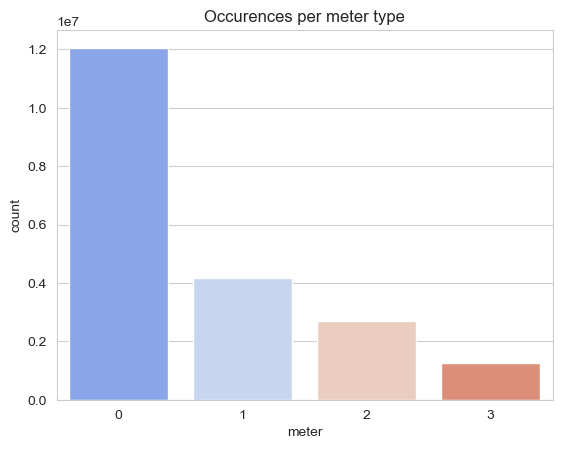

In [19]:
import seaborn as sns

sns.set_style('whitegrid')

# Set the color palette
colors = sns.color_palette('coolwarm', n_colors=4)

# Plot the countplot
sns.countplot(data=train_df, x='meter', palette=colors).set(title='Occurences per meter type')


As we can see that electricity meter is the most used

Mean Meter reading by hour and day

In [20]:
#Transformations
train_copy = train_df.copy()
test_copy = test_df.copy()


In [21]:
# We will break the timestamp into hour of the day, day of week, month and the year for the EDA in the copy of the train_df and test_df for some plots
# Maybe the timestamp column should be drop during training stage.

def break_datetime(df):
  df['timestamp']= pd.to_datetime(df['timestamp'])
  df['hour']= np.uint8(df['timestamp'].dt.hour)
  df['dayofweek']= np.uint8(df['timestamp'].dt.dayofweek)
  df['month']= np.uint8(df['timestamp'].dt.month)
  df['dayofyear']= np.uint16(df['timestamp'].dt.dayofyear)
  df['day']= np.uint16(df['timestamp'].dt.day) #day of month
  df['year']= np.uint16(df['timestamp'].dt.year)
  return df

In [22]:
train_copy = break_datetime(train_df)

In [23]:
test_copy = break_datetime(test_df)

In [27]:
train_copy['meter_reading_log'] = np.log1p(train_copy['meter_reading'])

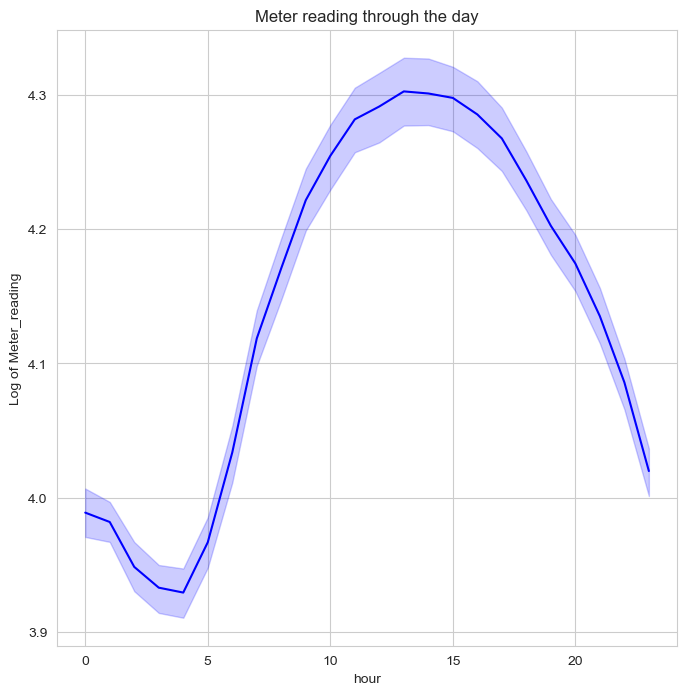

In [28]:
#This code plots the average hourly usage throughout the day.
plt.figure(figsize=(8,8))
hour_df= train_copy.groupby(['timestamp','hour']).meter_reading_log.mean().reset_index() # every hour's mean usage
sns.lineplot(x=hour_df['hour'], y=hour_df['meter_reading_log'], color='blue')
plt.ylabel("Log of Meter_reading")
plt.title("Meter reading through the day")
plt.show()

Based on the given plot, it can be observed that there is a dip in meter readings during the early hours of the morning, around 4am, followed by a gradual rise after 6am. The highest hourly usage is observed in the afternoon, around 3pm, which can be attributed to the operational hours of institutions, industries, and other buildings. As the day progresses beyond 3pm, the energy usage starts to decline. This pattern indicates a predictable trend in energy usage across the day, with usage peaking during operational hours and tapering off thereafter.

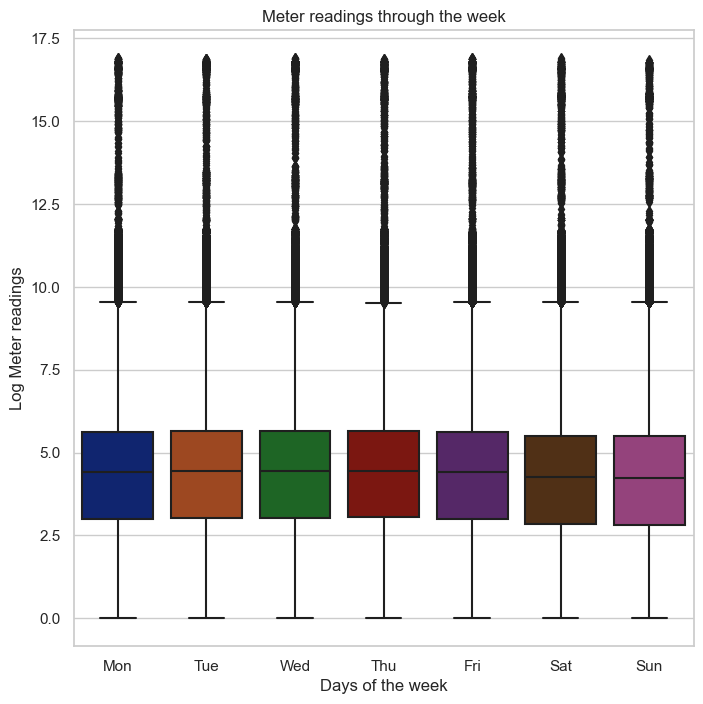

In [29]:
#Lets check the day wise usage of power
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,8))
day_labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
p=sns.boxplot(x=train_copy['dayofweek'], y=train_df['meter_reading_log'], palette='dark')
p.set_xticklabels(day_labels)
plt.xlabel("Days of the week")
plt.ylabel("Log Meter readings")
plt.title("Meter readings through the week")
plt.show()


The daily energy usage appears to be consistent with not much variation observed between days. However, the energy usage during weekends is relatively lower compared to weekdays, which can be attributed to the closure of companies and educational institutions on Sundays. Additionally, there are several outliers in the data where energy consumption is significantly higher than usual.

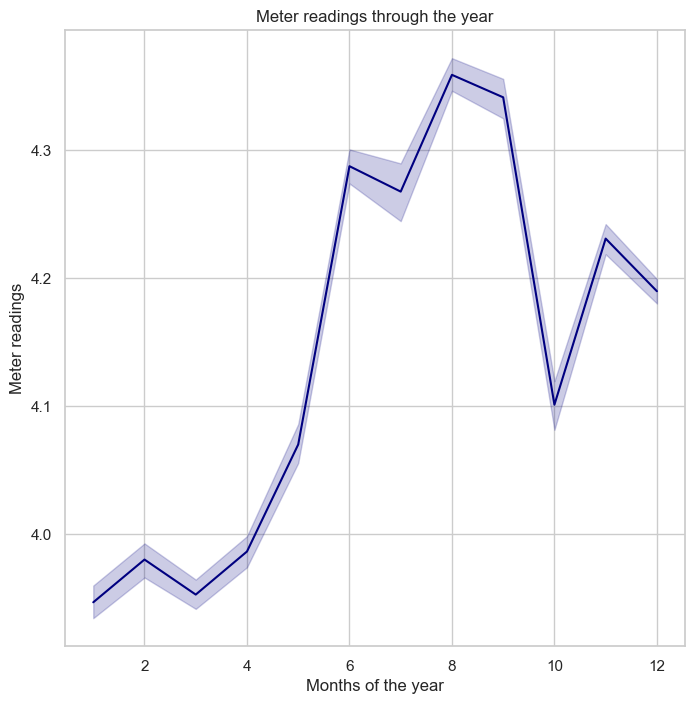

In [30]:
#Lets check the month wise usage of power
plt.figure(figsize=(8,8))
month_df= train_copy.groupby(['timestamp','month']).meter_reading_log.mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['meter_reading_log'], color='navy')
plt.xlabel("Months of the year")
plt.ylabel("Meter readings")
plt.title("Meter readings through the year")
plt.show()


The average monthly energy consumption is relatively low in the first few months and increases gradually after April. The consumption reaches its peak in August before starting to decline.

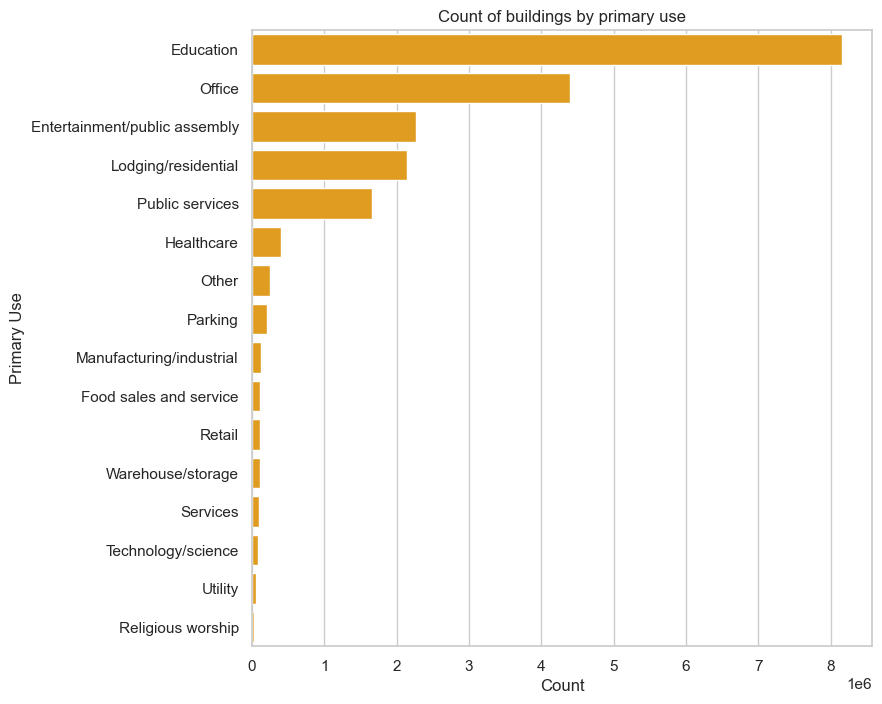

In [31]:
plt.figure(figsize=(8,8))
sns.countplot(y='primary_use', data=train_df, order = train_df['primary_use'].value_counts().index, color='orange')
plt.title('Count of buildings by primary use')
plt.xlabel('Count')
plt.ylabel('Primary Use')
plt.show()


the highest number of readings for energy consumption in educational institutes, followed by offices, entertainment venues, and lodging/residential buildings.

### Avg. consumption acc. to Primary Use

<font size='4'>On Hourly Basis</font>

In [33]:
import plotly.express as px
primary_use_df = train_copy.groupby(['hour', 'primary_use']).meter_reading_log.mean().reset_index()
px.line(primary_use_df, x="hour", y="meter_reading_log", color='primary_use', width=1000, height=600, title = 'Consumption by primary use on Hourly Avg')

<font size='4'>On Daily Basis</font>

In [42]:
primary_use_df = train_copy.groupby(['dayofweek', 'primary_use']).meter_reading_log.mean().reset_index()
px.line(primary_use_df, x="dayofweek", y="meter_reading_log", color='primary_use', width=900, height=600, title = 'Consumption by primary use on Daily')

The figure displays the average daily energy consumption for various primary usage categories. It is evident from the plots that energy consumption is typically the lowest on Sundays for all building types, except for food sales buildings, which have the lowest consumption on Saturdays. It's worth noting that the 0 value on the x-axis represents Monday, and not Sunday, which is consistent with the standard convention.

<font size='4'>On Monthly Basis</font>

In [35]:
primary_use_df = train_copy.groupby(['month', 'primary_use']).meter_reading_log.mean().reset_index()
px.line(primary_use_df, x="month", y="meter_reading_log", color='primary_use', width=1000, height=600, title = 'Consumption by primary use on Monthly')

Observations: 
    
The above graph shows the average hourly usage for each primary usage category. Educational institutes show their peak usage in August and September while the usage is minimum during the initial months of the year. Entertainment buildings show a rising trend in consumption from March to August. In contrast, manufacturing usage has a clear decreasing trend hitting the lowest point in July and then gradually increasing.

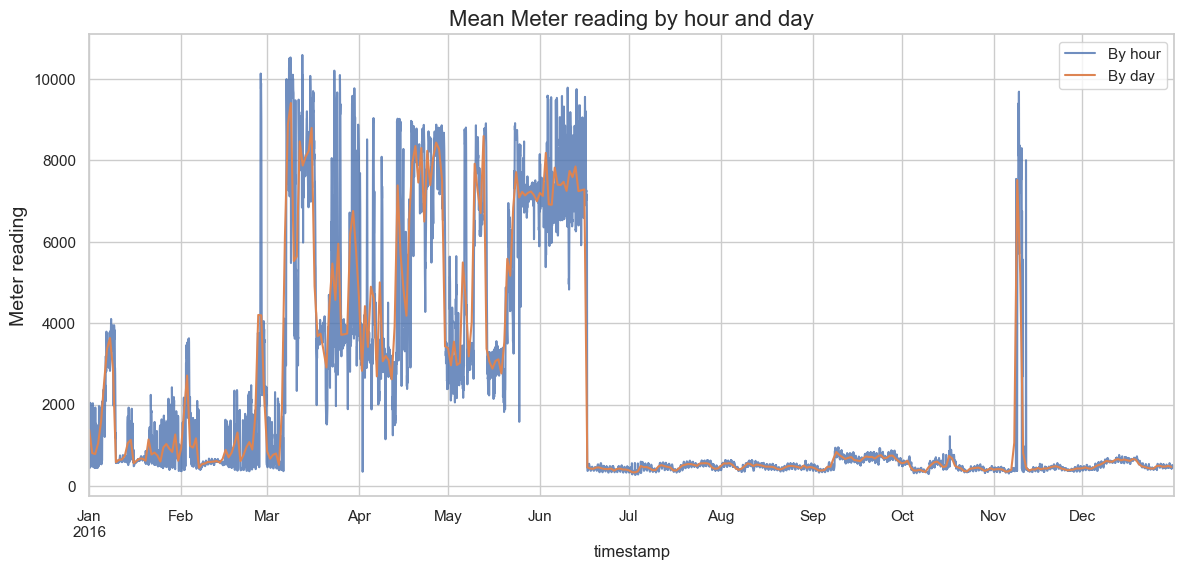

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
train_df[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='By hour', alpha=0.8).set_ylabel('Meter reading', fontsize=14);
train_df[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='By day', alpha=1).set_ylabel('Meter reading', fontsize=14);
axes.set_title('Mean Meter reading by hour and day', fontsize=16);
axes.legend();

The trend is bizarre as at the beginning from Jan to March it is uniform average then it surges till June and suddenly drops to 0 with a single peak in November.
Lets plot this graph for different sites and see whats causing this

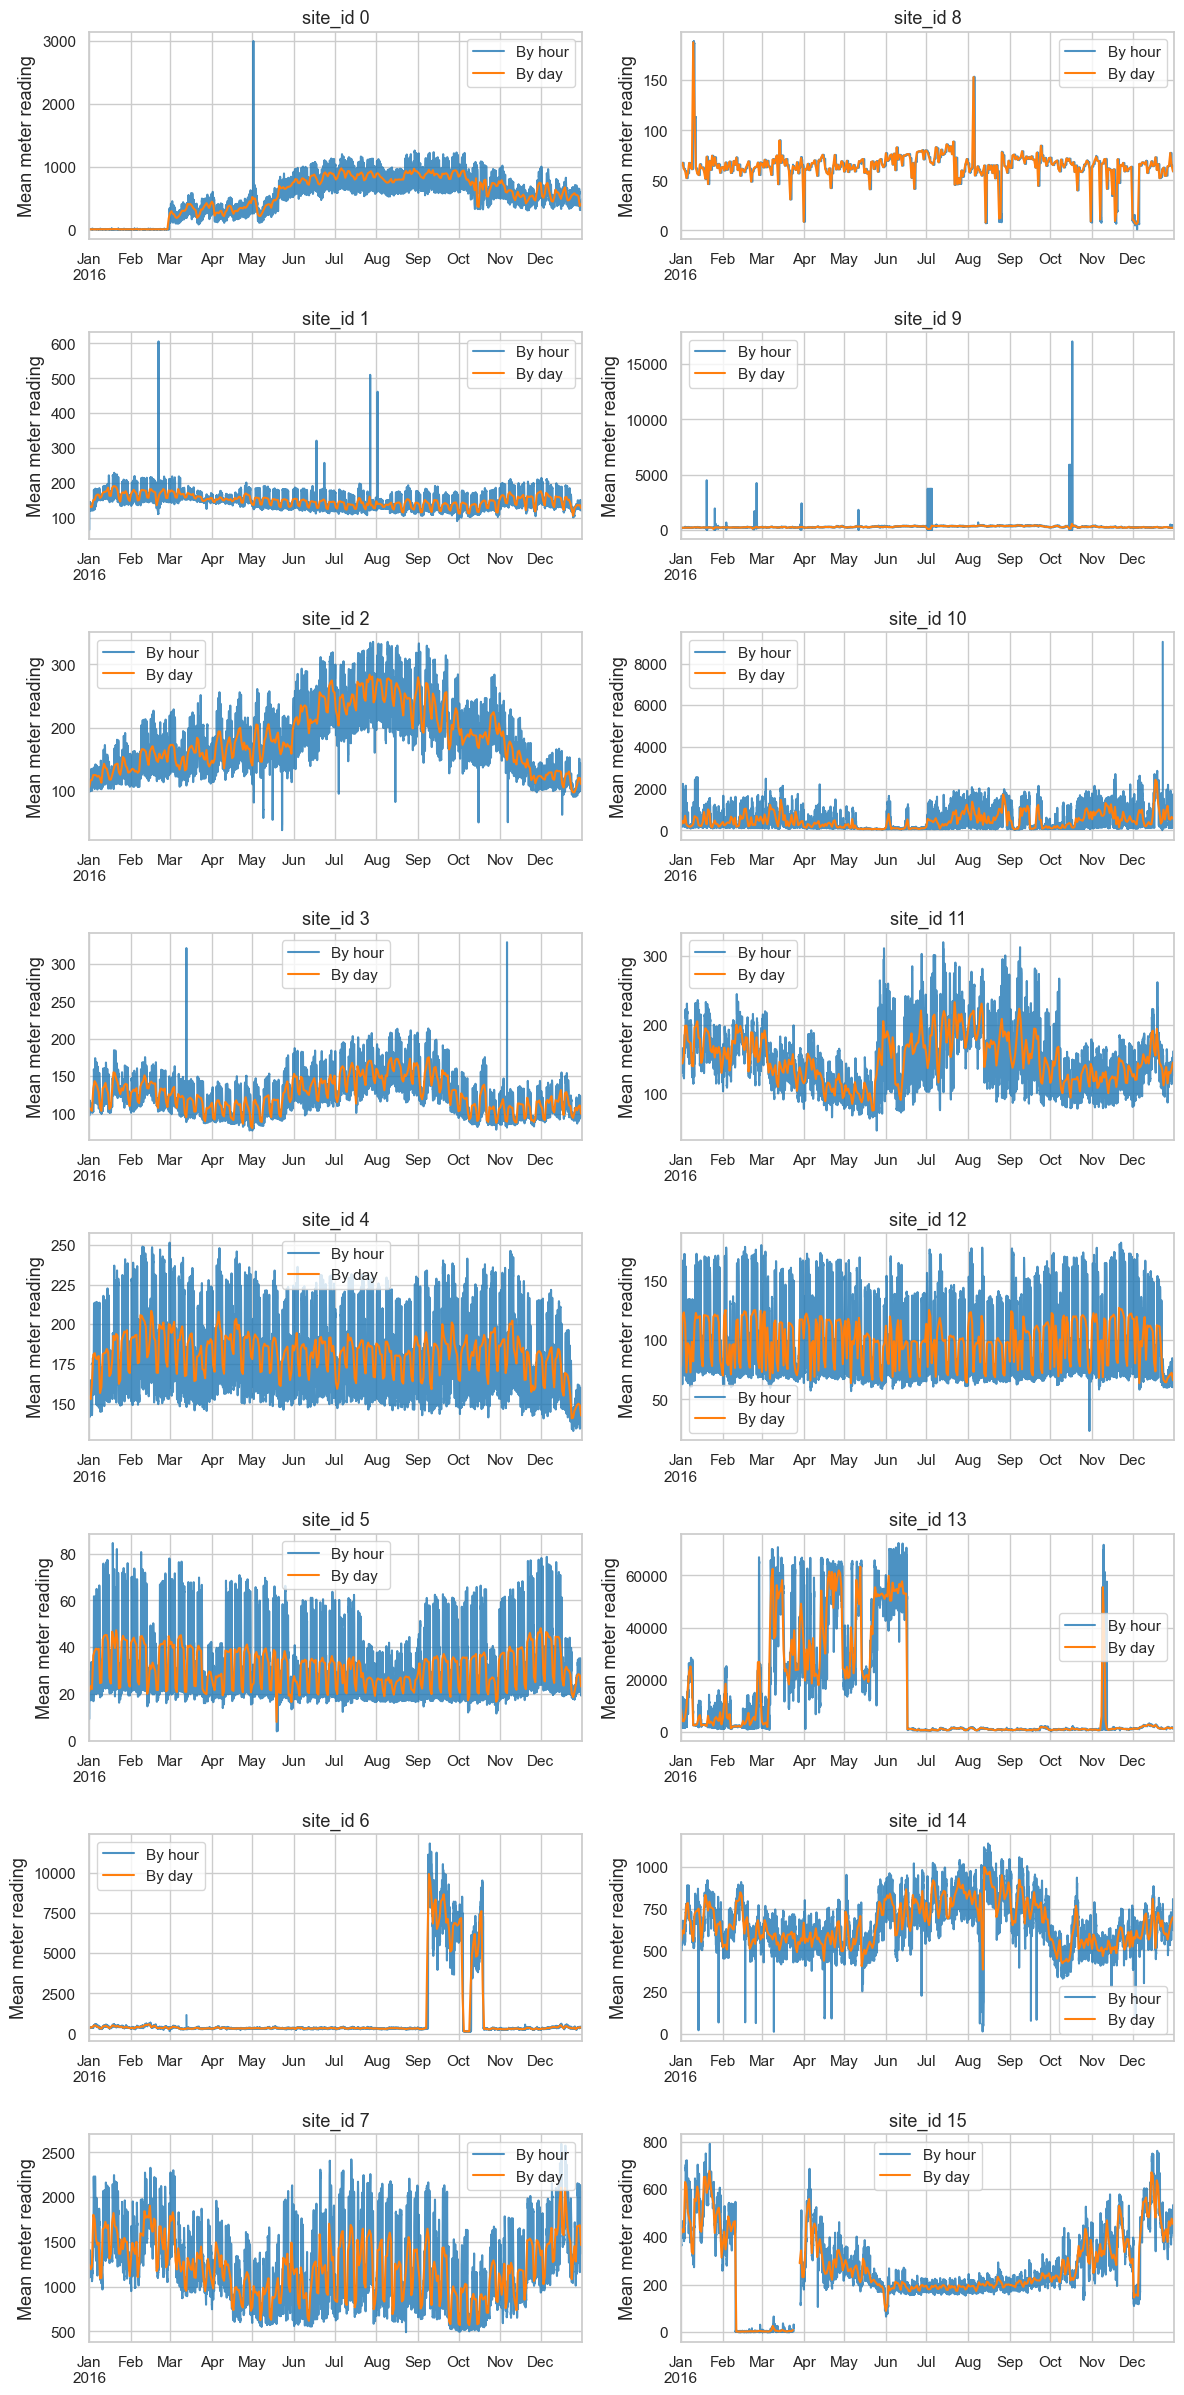

In [37]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i in range(train_df['site_id'].nunique()):
    train_df[train_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train_df[train_df['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
    plt.subplots_adjust(hspace=0.45)

Now we can deduce two things from here, firstly site 0 has no meter reading till march which will adversely affect the model performance and must be removed. Secondly Site 13 has similar pattern as the overall meter reading average. lets look deeper into site 13 with each primary use.

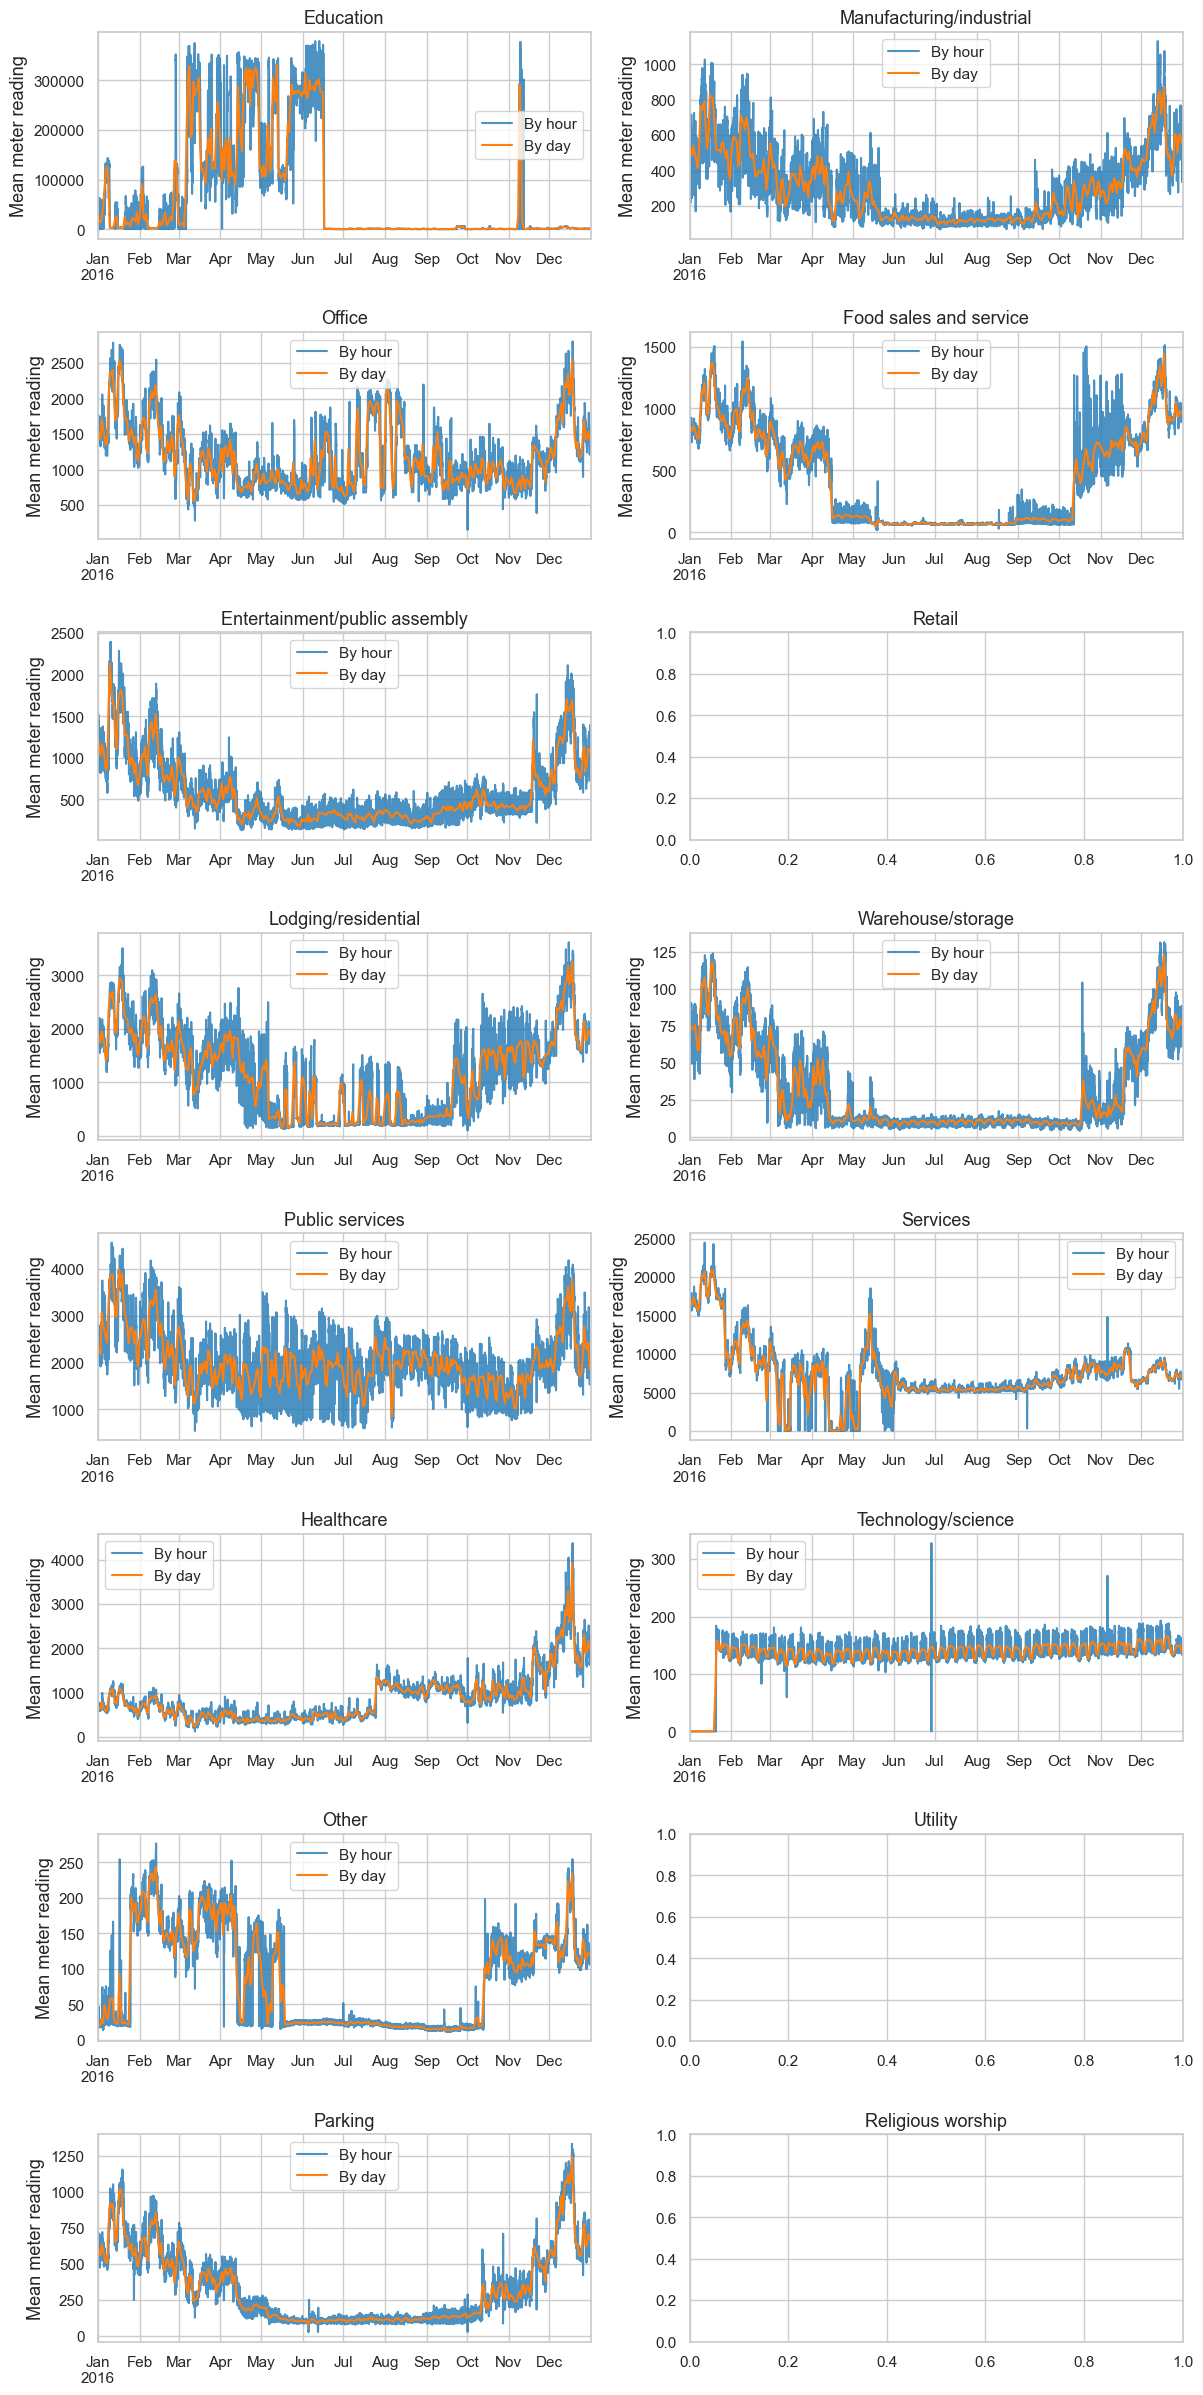

In [39]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
for i, use in enumerate(train_df['primary_use'].value_counts().index.to_list()):
    try:
        df = train_df[(train_df['site_id'] == 13) & (train_df['primary_use'] == use)]
        if len(df) > 0:
            df[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
            df[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=1, label='By day', color='tab:orange').set_xlabel('');
            axes[i%8][i//8].legend();
    except TypeError:
        pass
    axes[i%8][i//8].set_title(use, fontsize=13);
    plt.subplots_adjust(hspace=0.45)


Getting further into this, it can be observed that the primary use= Education looks like the general trend we captured above. Now we can visualize the education with respect to different meter types and look further. 

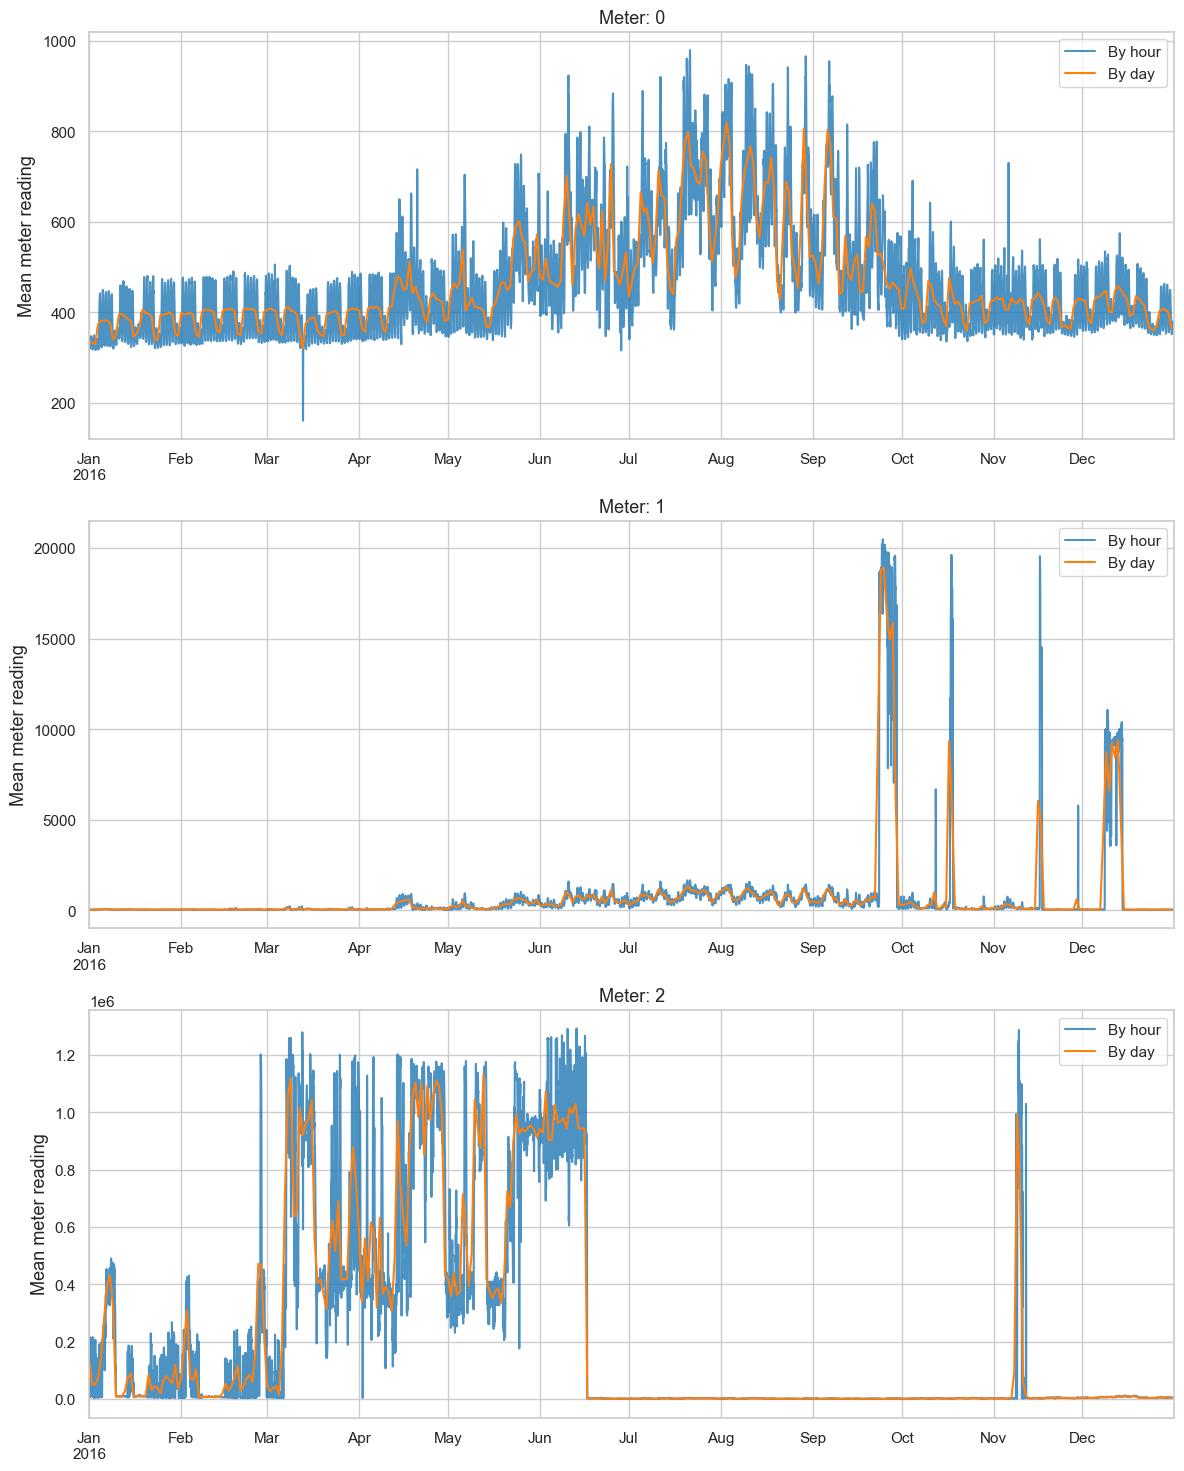

In [40]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
for i in train_df[(train_df['site_id'] == 13) & (train_df['primary_use'] == 'Education')]['meter'].value_counts(dropna=False).index.to_list():
    train_df[(train_df['site_id'] == 13) & (train_df['primary_use'] == 'Education') & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train_df[(train_df['site_id'] == 13) & (train_df['primary_use'] == 'Education') & (train_df['meter'] == i)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i].legend();
    axes[i].set_title('Meter: ' + str(i), fontsize=13);

It is getting clearer and we can state that at site 13, educational building and meter no.2 are causing this ambiguity. Lets visualize all the buildings that fall under this category.

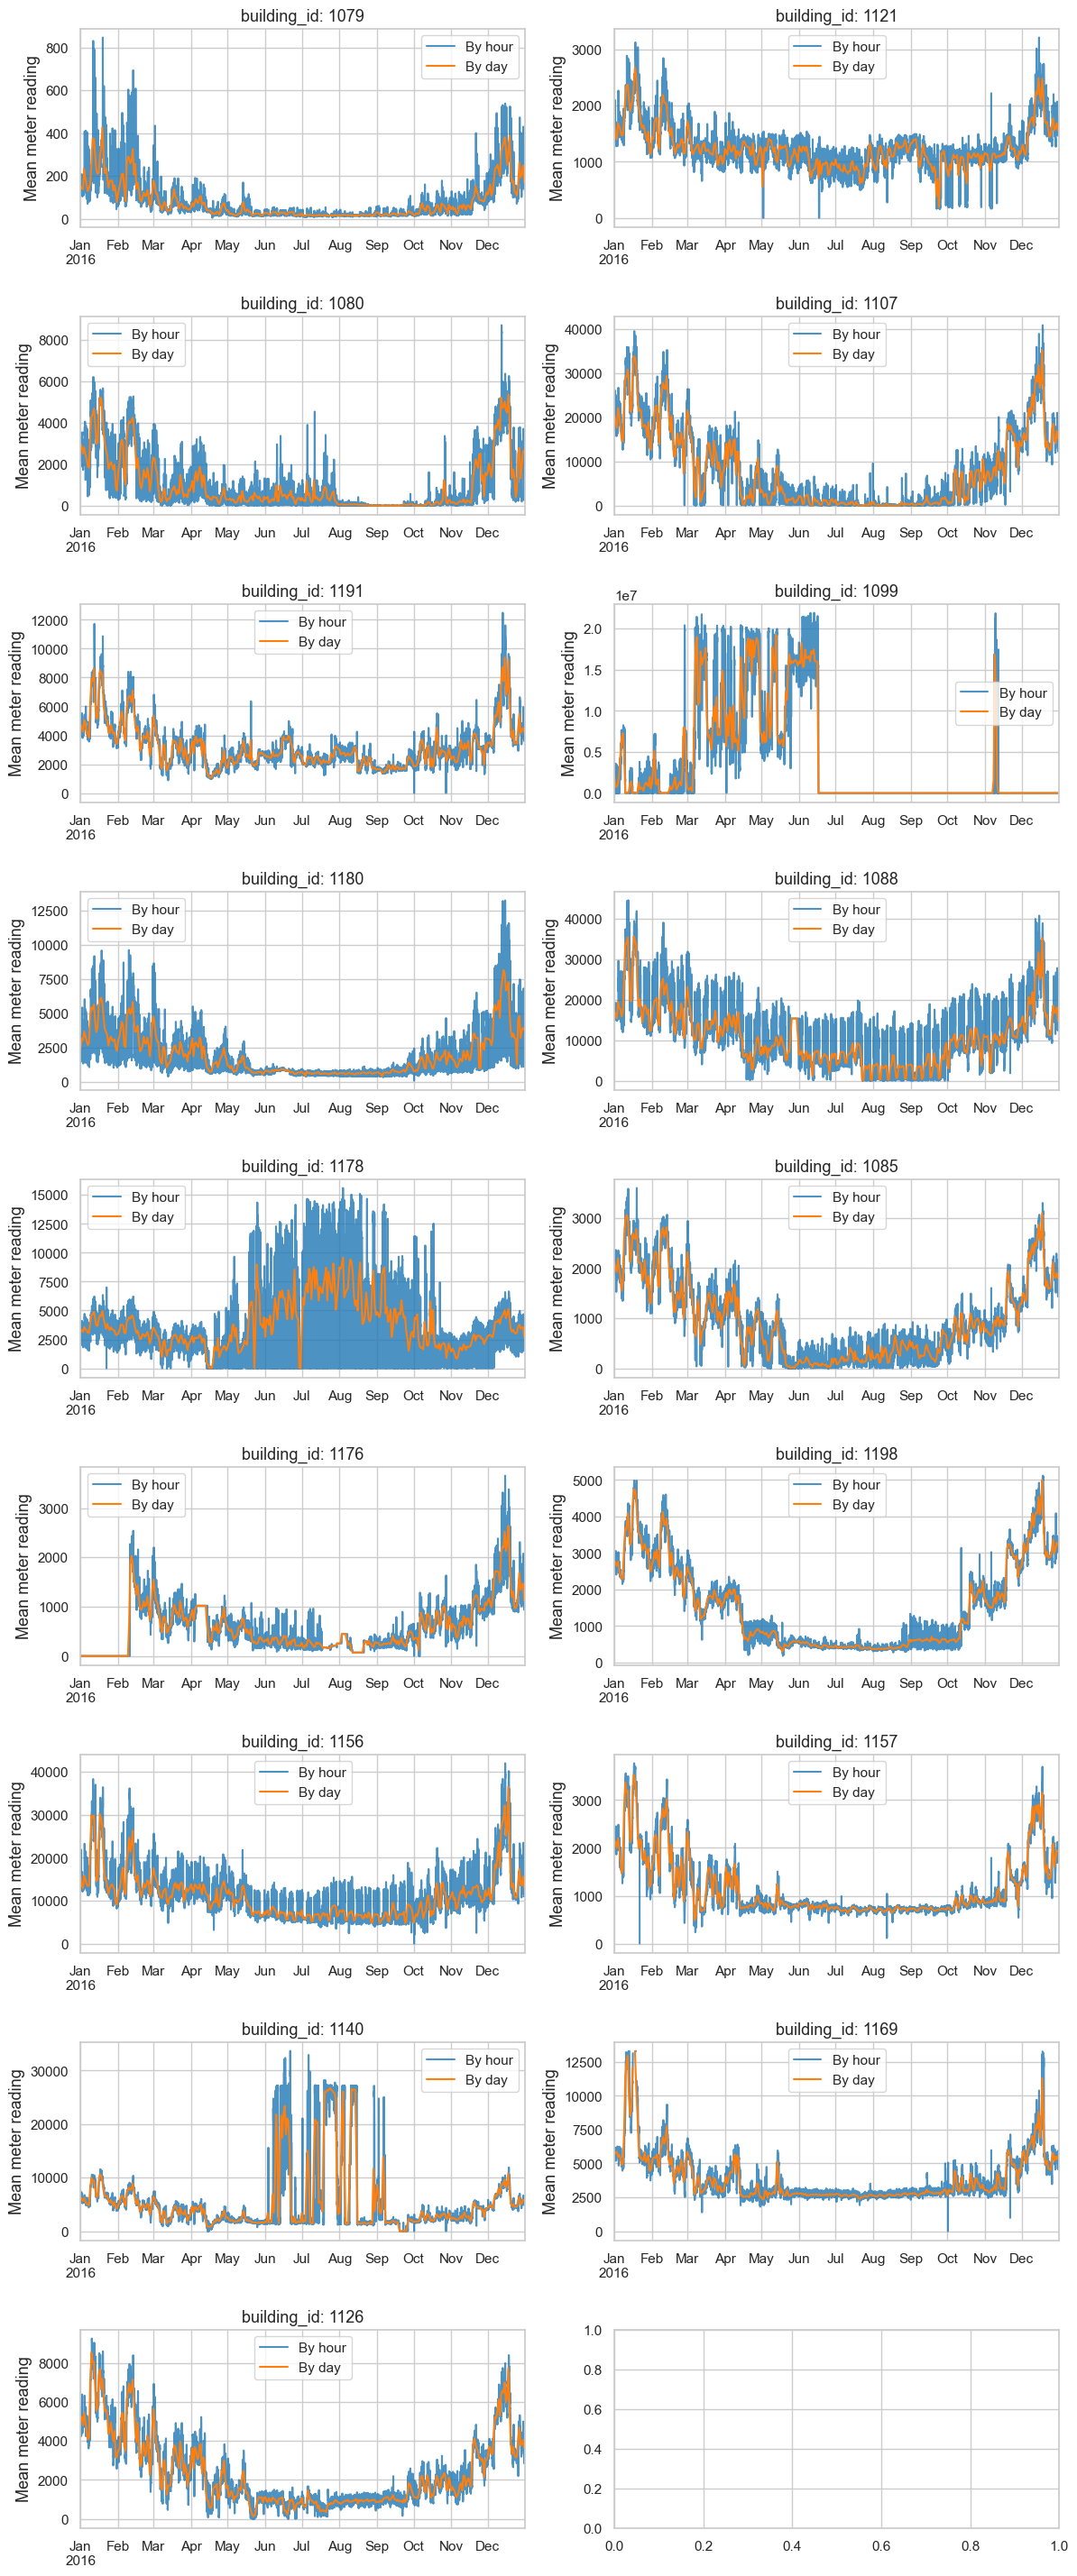

In [43]:
fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
for i, building in enumerate(train_df[(train_df['site_id'] == 13) & (train_df['primary_use'] == 'Education') & (train_df['meter'] == 2)]['building_id'].value_counts(dropna=False).index.to_list()):
    train_df[(train_df['site_id'] == 13) & (train_df['primary_use'] == 'Education') & (train_df['meter'] == 2) & (train_df['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
    train_df[(train_df['site_id'] == 13) & (train_df['primary_use'] == 'Education') & (train_df['meter'] == 2) & (train_df['building_id'] == building)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9], alpha=1, label='By day', color='tab:orange').set_xlabel('');
    axes[i%9][i//9].legend();
    axes[i%9][i//9].set_title('building_id: ' + str(building), fontsize=13);
    plt.subplots_adjust(hspace=0.45)


Now we can undoubetly claim that building id: 1099 is causing the issue. lets exclude building 1099 and visualize the dataset along with mean meter reading for the whole dataset.

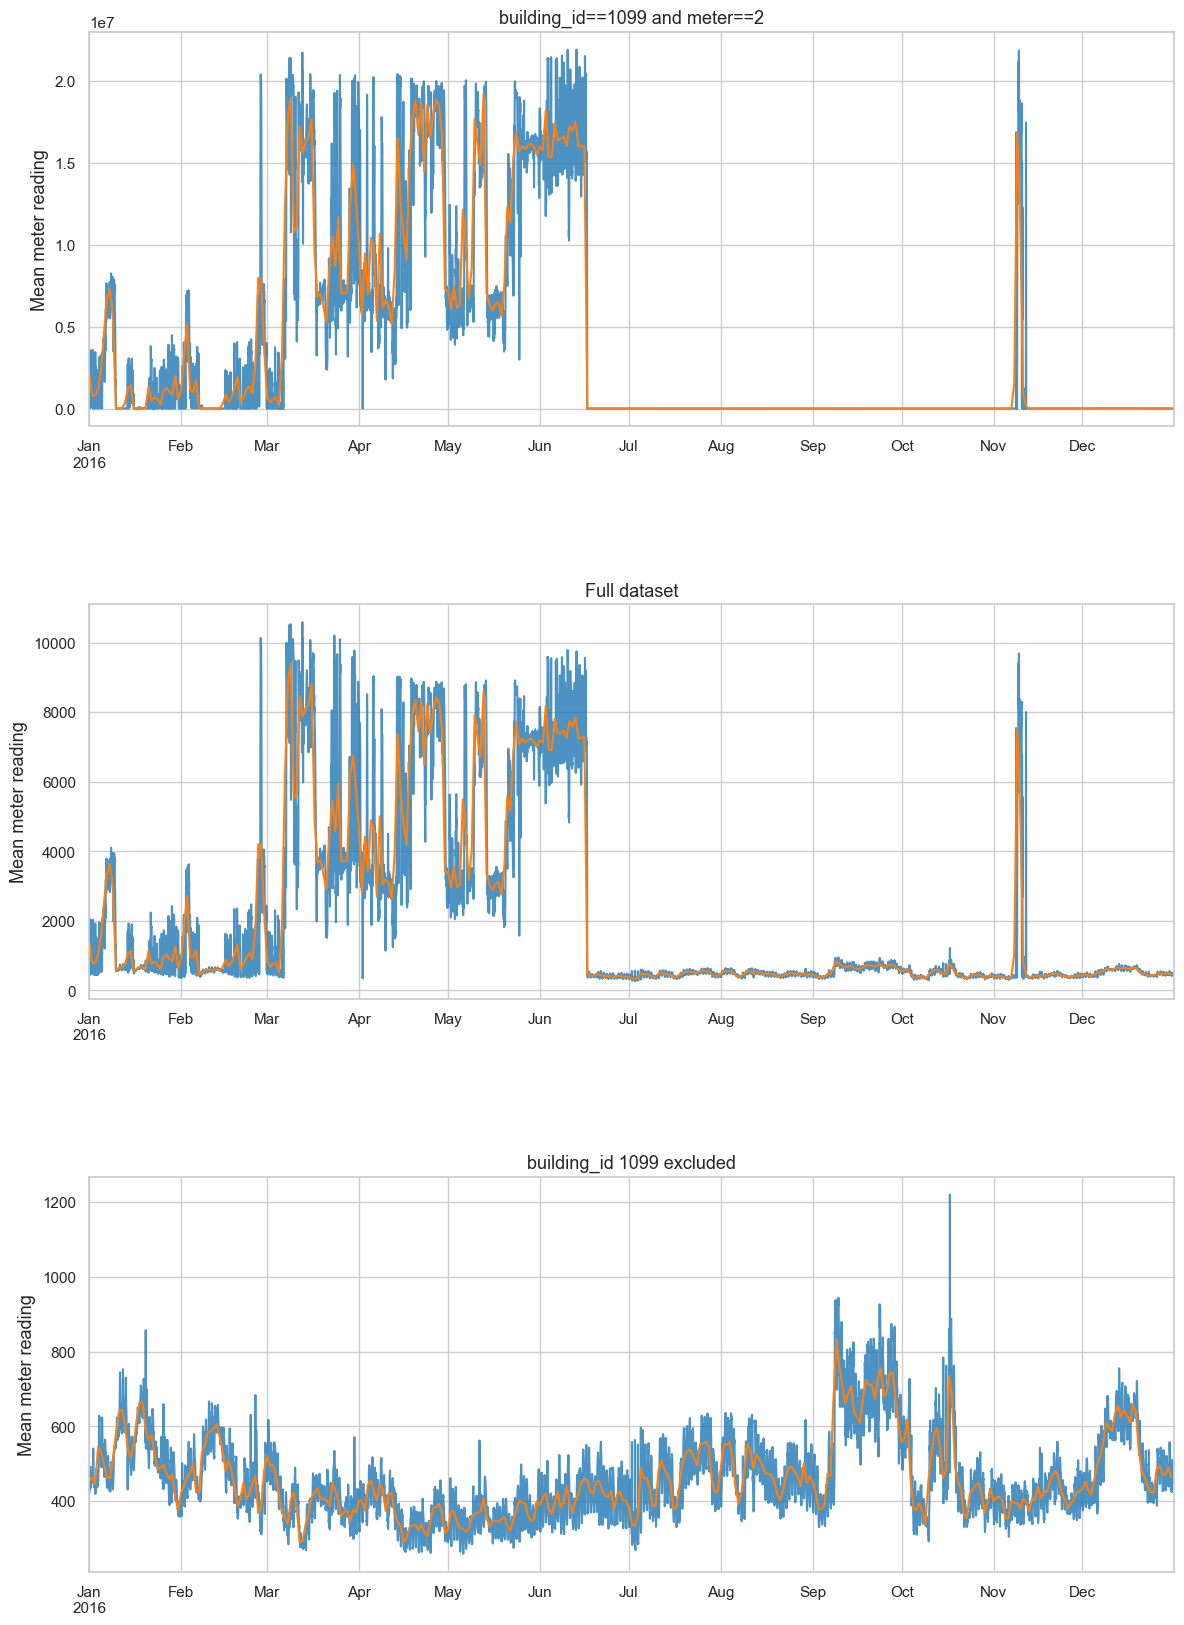

In [44]:
fig, axes = plt.subplots(3,1,figsize=(14, 20), dpi=100)

train_df[(train_df['meter'] == 2) & (train_df['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[0], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train_df[(train_df['meter'] == 2) & (train_df['building_id'] == 1099)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[0], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train_df[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[1], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train_df[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[1], alpha=1, label='By day', color='tab:orange').set_xlabel('');

train_df[~((train_df['meter'] == 2) & (train_df['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[2], alpha=0.8, label='By hour', color='tab:blue').set_ylabel('Mean meter reading', fontsize=13);
train_df[~((train_df['meter'] == 2) & (train_df['building_id'] == 1099))][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[2], alpha=1, label='By day', color='tab:orange').set_xlabel('');

axes[0].set_title('building_id==1099 and meter==2', fontsize=13);
axes[1].set_title('Full dataset', fontsize=13);
axes[2].set_title('building_id 1099 excluded', fontsize=13);
plt.subplots_adjust(hspace=0.45)


One interesting thing to notice is that the number of observations per day is same for test but different for train.

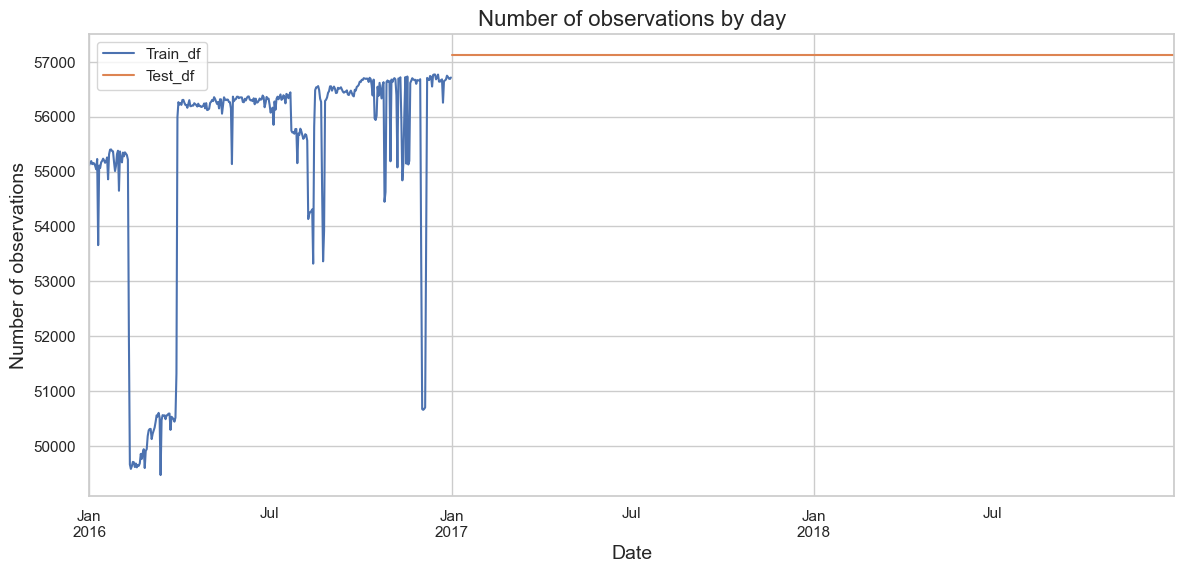

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train_df['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test_df['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train_df', 'Test_df']);


Now lets visualise meter types which are distributed as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3} and see where the mean meter reading is the highest.

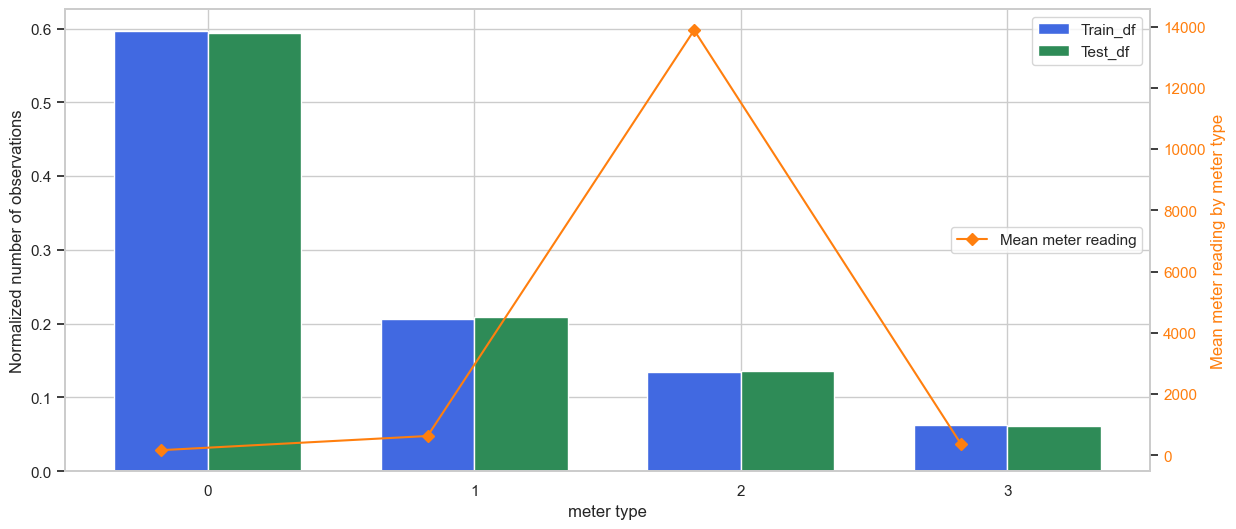

In [46]:
train_df_data = train_df['meter'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_df_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_df_data, width, color='royalblue')

test_df_data = test_df['meter'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_df_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('meter type');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_df['meter'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train_df[['meter', 'meter_reading']].groupby('meter')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by meter type', color='tab:orange');
axes.legend([tr, tt], ['Train_df', 'Test_df'], facecolor='white');
axes2.legend(loc=5, facecolor='white');



We can conclude that using steam consumes the most energy and is the most inefficient way since it has the highest meter reading.

Meter 0 has the greatest readings

[Text(0.5, 1.0, 'Occurences per meter type')]

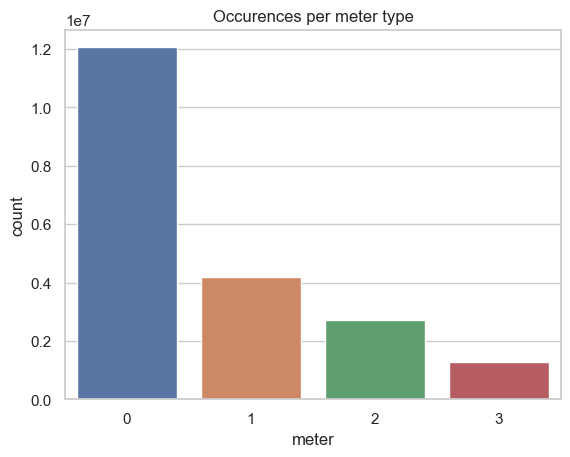

In [47]:
sns.countplot(data=train_df, x='meter').set(title='Occurences per meter type')


## Identifying Outliers

In [48]:
train_df.describe()

building_id         meter  meter_reading       site_id   square_feet  \
count  2.021610e+07  2.021610e+07   2.021610e+07  2.021610e+07  2.021610e+07   
mean   7.992780e+02  6.624412e-01   2.117122e+03  7.992232e+00  1.077830e+05   
std    4.269133e+02  9.309921e-01   1.532159e+05  5.099060e+00  1.171424e+05   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  2.830000e+02   
25%    3.930000e+02  0.000000e+00   1.830000e+01  3.000000e+00  3.252700e+04   
50%    8.950000e+02  0.000000e+00   7.877500e+01  9.000000e+00  7.270900e+04   
75%    1.179000e+03  1.000000e+00   2.679840e+02  1.300000e+01  1.391130e+05   
max    1.448000e+03  3.000000e+00   2.190470e+07  1.500000e+01  8.750000e+05   

       year_built  floor_count  air_temperature  cloud_coverage  \
count   8088455.0    3506933.0     2.011944e+07      11390735.0   
mean          NaN          NaN              NaN             NaN   
std           NaN          0.0     0.000000e+00             0.0   
min        1900.0          1.0    -2.890625e+01             0.0   
25%        1951.0          1.0     8.601562e+00             0.0   
50%        1969.0          3.0     1.670312e+01             0.0   
75%        1993.0          6.0     2.409375e+01             4.0   
max        2017.0         26.0     4.718750e+01             9.0   

       dew_temperature  ...  sea_level_pressure  wind_direction    wind_speed  \
count     2.011596e+07  ...          18984431.0      18767052.0  2.007242e+07   
mean               NaN  ...                 NaN             NaN           NaN   
std       0.000000e+00  ...                 NaN             NaN  0.000000e+00   
min      -3.500000e+01  ...               968.0             0.0  0.000000e+00   
25%       0.000000e+00  ...              1011.5            70.0  2.099609e+00   
50%       8.898438e+00  ...              1016.0           180.0  3.099609e+00   
75%       1.609375e+01  ...              1020.5           280.0  4.601562e+00   
max       2.609375e+01  ...              1046.0           360.0  1.900000e+01   

               hour     dayofweek         month     dayofyear           day  \
count  2.021610e+07  2.021610e+07  2.021610e+07  2.021610e+07  2.021610e+07   
mean   1.150232e+01  3.006958e+00  6.578453e+00  1.854788e+02  1.576123e+01   
std    6.922017e+00  1.997191e+00  3.436662e+00  1.052632e+02  8.820535e+00   
min    0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    6.000000e+00  1.000000e+00  4.000000e+00  9.600000e+01  8.000000e+00   
50%    1.200000e+01  3.000000e+00  7.000000e+00  1.860000e+02  1.600000e+01   
75%    1.800000e+01  5.000000e+00  1.000000e+01  2.760000e+02  2.300000e+01   
max    2.300000e+01  6.000000e+00  1.200000e+01  3.660000e+02  3.100000e+01   

             year  meter_reading_log  
count  20216100.0       2.021610e+07  
mean       2016.0       4.145761e+00  
std           0.0       2.074255e+00  
min        2016.0       0.000000e+00  
25%        2016.0       2.960105e+00  
50%        2016.0       4.379210e+00  
75%        2016.0       5.594652e+00  
max        2016.0       1.690221e+01  

[8 rows x 21 columns]

As we can see in the meter reading column, there is a difference of 10^e5 between the mean and the max value. Which shows that there are outliers, lets check the outliers later.

In [49]:
test_df.describe()

row_id   building_id         meter       site_id   square_feet  \
count  4.169760e+07  4.169760e+07  4.169760e+07  4.169760e+07  4.169760e+07   
mean   2.084880e+07  8.075824e+02  6.642857e-01  8.086134e+00  1.069469e+05   
std    1.203706e+07  4.297680e+02  9.278067e-01  5.134712e+00  1.160888e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.830000e+02   
25%    1.042440e+07  4.047500e+02  0.000000e+00  3.000000e+00  3.224350e+04   
50%    2.084880e+07  9.000000e+02  0.000000e+00  9.000000e+00  7.226250e+04   
75%    3.127320e+07  1.194250e+03  1.000000e+00  1.300000e+01  1.383875e+05   
max    4.169760e+07  1.448000e+03  3.000000e+00  1.500000e+01  8.750000e+05   

       year_built  floor_count  air_temperature  cloud_coverage  \
count  17099520.0    7253280.0     4.147570e+07      22155420.0   
mean          NaN          NaN              NaN             NaN   
std           NaN          0.0     0.000000e+00             0.0   
min        1900.0          1.0    -2.809375e+01             0.0   
25%        1951.0          1.0     7.800781e+00             0.0   
50%        1969.0          3.0     1.670312e+01             2.0   
75%        1993.0          6.0     2.390625e+01             4.0   
max        2017.0         26.0     4.831250e+01             9.0   

       dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
count     4.143680e+07         33896037.0          39180774.0      38718937.0   
mean               NaN                NaN                 NaN             NaN   
std       0.000000e+00                NaN                 NaN             NaN   
min      -3.159375e+01               -1.0               972.0             0.0   
25%       0.000000e+00                0.0              1011.5            80.0   
50%       8.898438e+00                0.0              1016.0           180.0   
75%       1.670312e+01                0.0              1020.5           280.0   
max       2.670312e+01              597.0              1050.0           360.0   

         wind_speed          hour     dayofweek         month     dayofyear  \
count  4.139551e+07  4.169760e+07  4.169760e+07  4.169760e+07  4.169760e+07   
mean            NaN  1.150000e+01  3.000000e+00  6.526027e+00  1.830000e+02   
std    0.000000e+00  6.922187e+00  2.003422e+00  3.447851e+00  1.053660e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
25%    2.099609e+00  5.750000e+00  1.000000e+00  4.000000e+00  9.200000e+01   
50%    3.099609e+00  1.150000e+01  3.000000e+00  7.000000e+00  1.830000e+02   
75%    4.601562e+00  1.725000e+01  5.000000e+00  1.000000e+01  2.740000e+02   
max    2.420312e+01  2.300000e+01  6.000000e+00  1.200000e+01  3.650000e+02   

                day        year  
count  4.169760e+07  41697600.0  
mean   1.572055e+01      2017.5  
std    8.796247e+00         0.5  
min    1.000000e+00      2017.0  
25%    8.000000e+00      2017.0  
50%    1.600000e+01      2017.5  
75%    2.300000e+01      2018.0  
max    3.100000e+01      2018.0

In [50]:
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
import scipy.stats as st

In [51]:
num_col=['building_id','meter','meter_reading','square_feet','cloud_coverage','wind_direction','precip_depth_1_hr','sea_level_pressure','wind_speed', 'dew_temperature', 'air_temperature']

In [52]:
out_per=[]
for i in num_col:
    data_mean, data_std = mean(train_df[i]), std(train_df[i])
# identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    print(i,': \n')
# identify outliers
    outliers = [x for x in train_df[i] if x < lower or x > upper]
    
    num_out=len(outliers)
    print('Identified outliers: %d' % num_out)
    outliers_removed = [x for x in train_df[i] if x >= lower and x <= upper]
    num_nout=len(outliers_removed)
    print('Non-outlier observations: %d' % num_nout)
    print('\n')

building_id : 

Identified outliers: 0
Non-outlier observations: 20216100


meter : 

Identified outliers: 0
Non-outlier observations: 20216100


meter_reading : 

Identified outliers: 3750
Non-outlier observations: 20212350


square_feet : 

Identified outliers: 445224
Non-outlier observations: 19770876


cloud_coverage : 

Identified outliers: 0
Non-outlier observations: 0


wind_direction : 

Identified outliers: 0
Non-outlier observations: 0


precip_depth_1_hr : 

Identified outliers: 0
Non-outlier observations: 0


sea_level_pressure : 

Identified outliers: 0
Non-outlier observations: 0


wind_speed : 

Identified outliers: 0
Non-outlier observations: 0


dew_temperature : 

Identified outliers: 0
Non-outlier observations: 0


air_temperature : 

Identified outliers: 0
Non-outlier observations: 0




In [53]:
train_df[train_df.meter_reading == train_df.meter_reading.max()]

building_id  meter           timestamp  meter_reading  site_id  \
8907488         1099      2 2016-06-13 09:00:00     21904700.0       13   

        primary_use  square_feet  year_built  floor_count  air_temperature  \
8907488   Education       332884         NaN          NaN         19.40625   

         ...  sea_level_pressure  wind_direction  wind_speed  hour  dayofweek  \
8907488  ...              1014.5            50.0    6.199219     9          0   

         month  dayofyear  day  year  meter_reading_log  
8907488      6        165   13  2016          16.902212  

[1 rows x 23 columns]

In [54]:
# Perform a one hot encoding
def one_hot(train, feature, test=None):
    train2 = train.copy()
    train2[f'{feature}s'] = train2[feature]
    train2 = pd.get_dummies(train2, columns=[feature], prefix=[f'{feature}_'])
    if test is None:
        return(train2)
    else:
        test2 = test.copy()
        test2[f'{feature}s'] = test2[feature]
        test2 = pd.get_dummies(test2, columns=[feature], prefix=[f'{feature}_'])
        return(train2, test2)


In [55]:
# One hot encoding of meter
train_df_copy = one_hot(train_df, 'meter')
test_df_copy = one_hot(test_df, 'meter')

In [56]:
for i in range(0,4):
    if 'meter_reading' in train_df.columns:
        train_df[f'meter__{i}'] = train_df_copy[f'meter__{i}']*train_df_copy['meter_reading']
    if 'meter_reading' in test_df.columns:
        test_df[f'meter__{i}'] = test_df_copy[f'meter__{i}']*test_df_copy['meter_reading']


[Text(0.5, 1.0, 'Boxplot without outliers')]

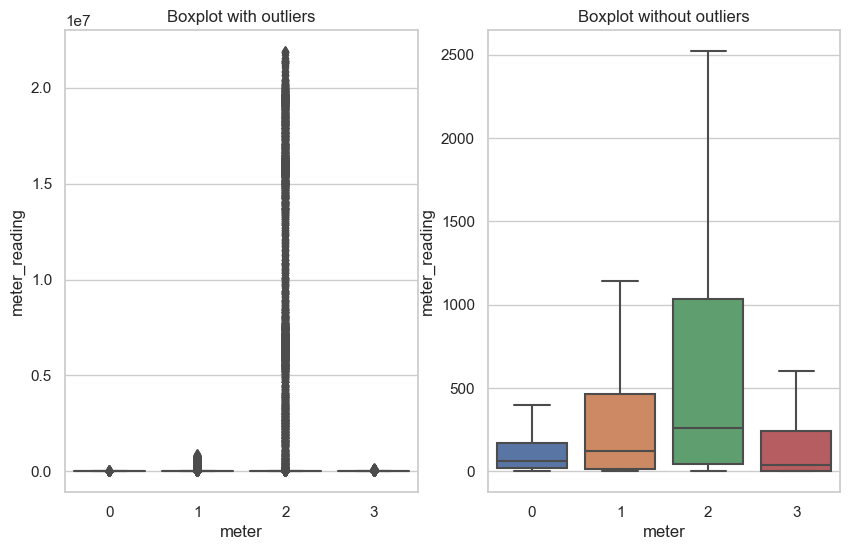

In [57]:
fig, axes = plt.subplots(1,2,figsize=(10,6))
sns.boxplot(x='meter', y='meter_reading', data=train_df, ax=axes[0]).set(title='Boxplot with outliers')
sns.boxplot(x='meter', y='meter_reading', data=train_df, ax=axes[1], showfliers=False).set(title='Boxplot without outliers')


Even with this plot we can observe that building 1099 is causing the vague high reading for meter 2

### Box plot of air temperature by meter type 

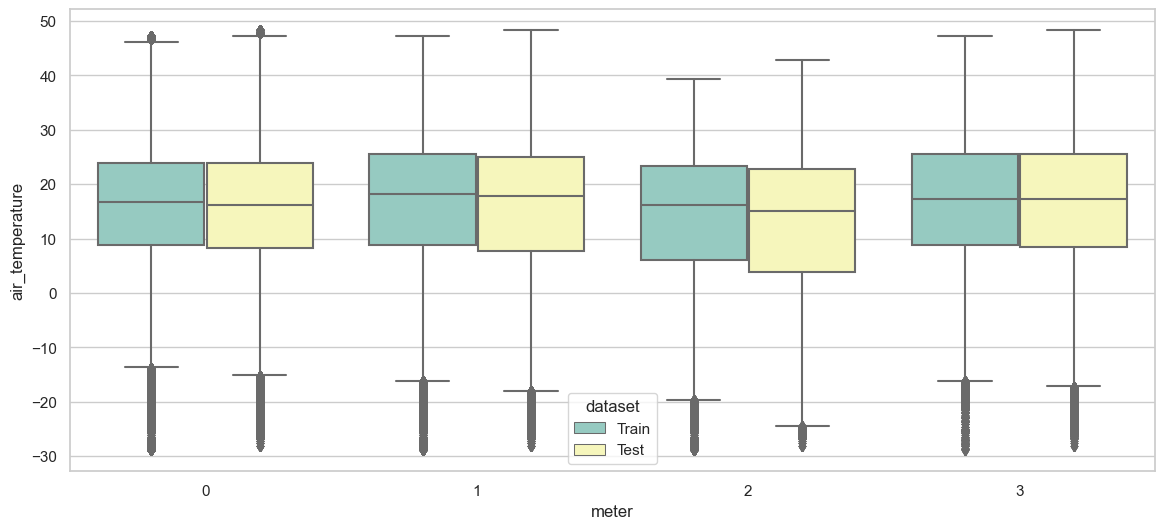

In [58]:
tmp_df = pd.concat([train_df[['meter', 'air_temperature']], test_df[['meter', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train_df), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='meter', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

### Site_id with Mean Meter Reading

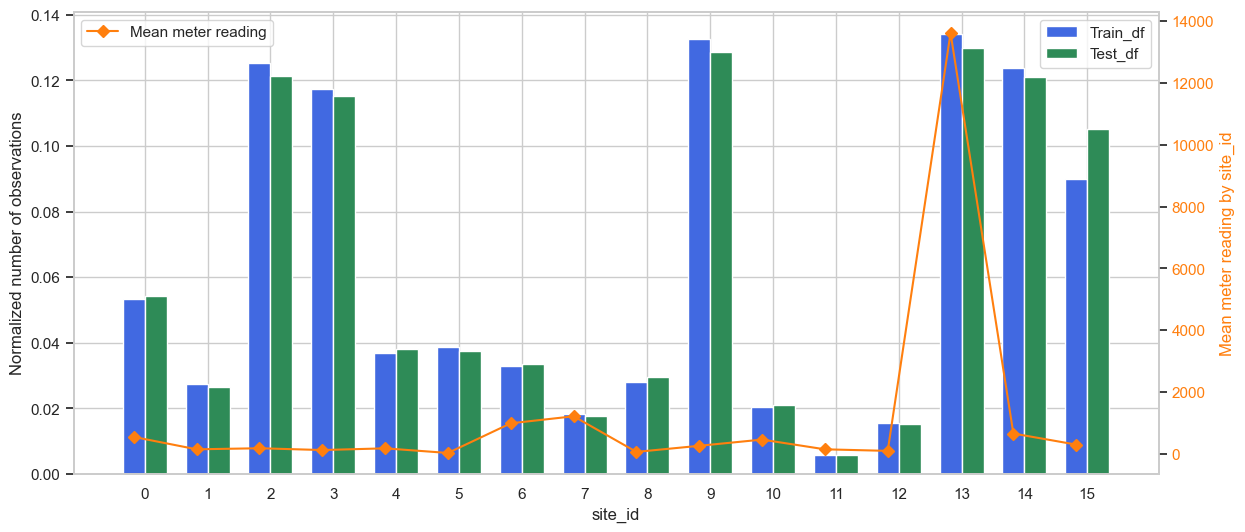

In [59]:
train_df_data = train_df['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(train_df_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_df_data, width, color='royalblue')

test_df_data = test_df['site_id'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, test_df_data, width, color='seagreen')

axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('site_id');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_df['site_id'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()
mr = axes2.plot(ind, train_df[['site_id', 'meter_reading']].groupby('site_id')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by site_id', color='tab:orange');
axes.legend([tr, tt], ['Train_df', 'Test_df'], facecolor='white');
axes2.legend(loc=2, facecolor='white');


### Box plot of meter reading by site_id with outliers removed

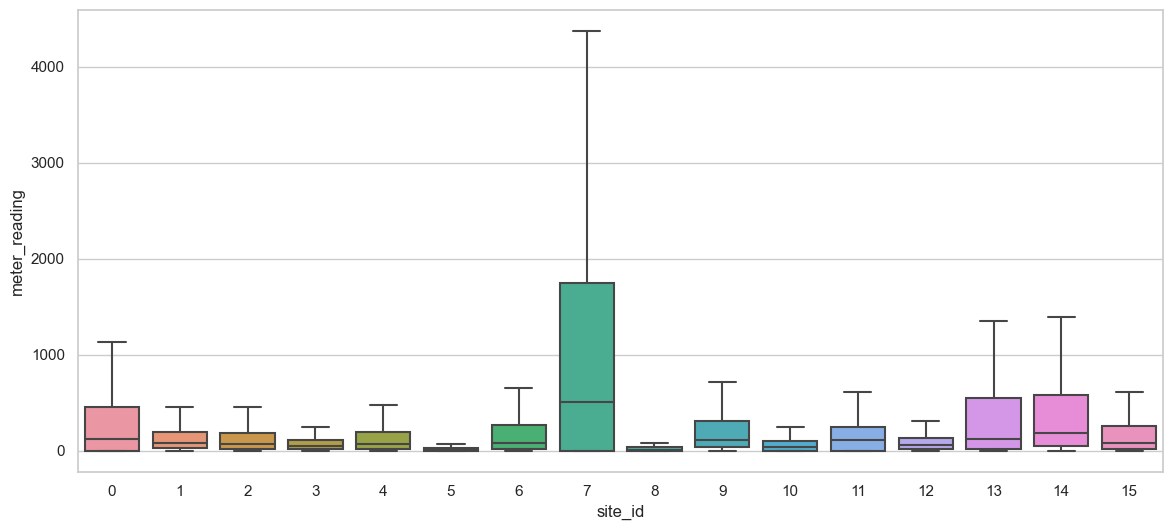

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train_df, showfliers=False);

### Box plot of air temperature by site_id

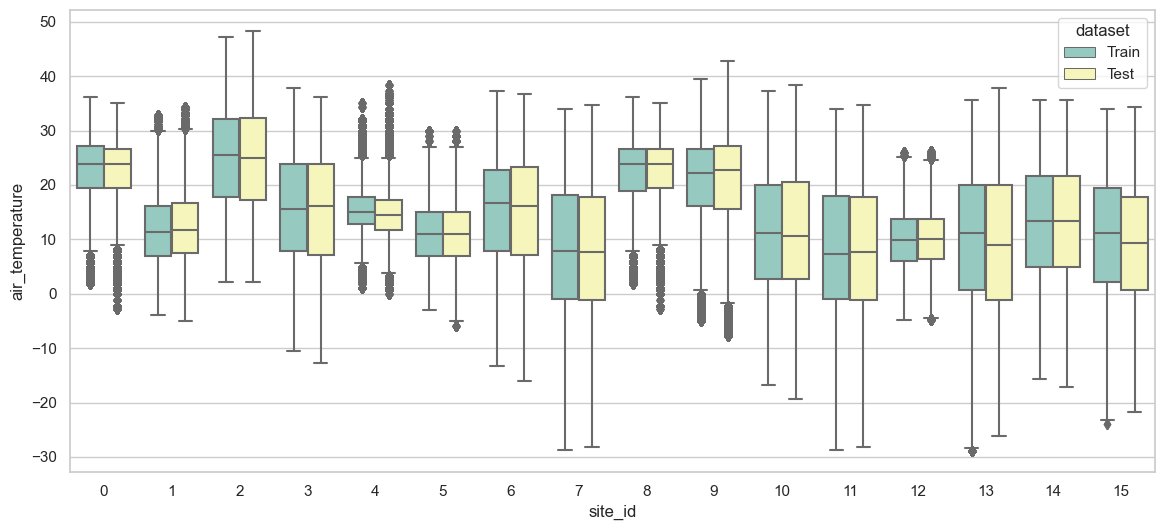

In [61]:
tmp_df = pd.concat([train_df[['site_id', 'air_temperature']], test_df[['site_id', 'air_temperature']]], ignore_index=True)
tmp_df['dataset'] = 'Train'
tmp_df.loc[tmp_df.index > len(train_df), 'dataset'] = 'Test'

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='air_temperature', data=tmp_df, hue='dataset', palette="Set3");

del tmp_df
gc.collect();

### Primary Use

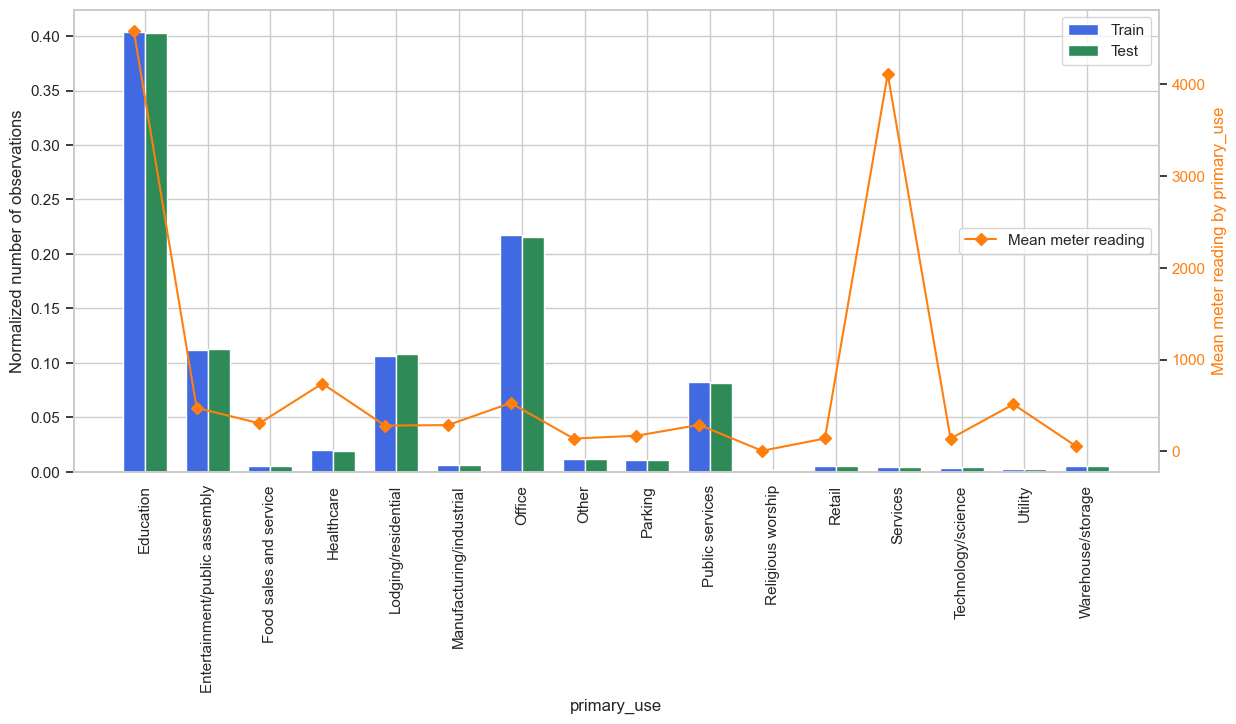

In [62]:
#Count the number of observations for each primary_use in the train_df dataset and normalize the values
train_data = train_df['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values

#Generate an array of evenly spaced values to be used as the x-axis
ind = np.arange(len(train_data))

#Set the width of the bars in the bar plot
width = 0.35

#Create a figure with a single set of axes
fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)

#Create a bar plot for the train data
tr = axes.bar(ind, train_data, width, color='royalblue')

#Count the number of observations for each primary_use in the test_df dataset and normalize the values
test_data = test_df['primary_use'].value_counts(dropna=False, normalize=True).sort_index().values

#Create a bar plot for the test data
tt = axes.bar(ind+width, test_data, width, color='seagreen')

#Set the label for the y-axis
axes.set_ylabel('Normalized number of observations');

#Set the label for the x-axis
axes.set_xlabel('primary_use');

#Set the position of the x-tick labels and the labels themselves
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_df['primary_use'].value_counts().sort_index().index, rotation=90)

#Create a second y-axis on the right-hand side of the plot
axes2 = axes.twinx()

#Plot the mean meter reading for each primary_use in the train_df dataset
mr = axes2.plot(ind, train_df[['primary_use', 'meter_reading']].groupby('primary_use')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');

#Remove the gridlines from the second y-axis and set the color of the y-axis labels
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');

#Set the label for the second y-axis
axes2.set_ylabel('Mean meter reading by primary_use', color='tab:orange');

#Add a legend to the plot with a white background
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=5, facecolor='white');

### Square feet

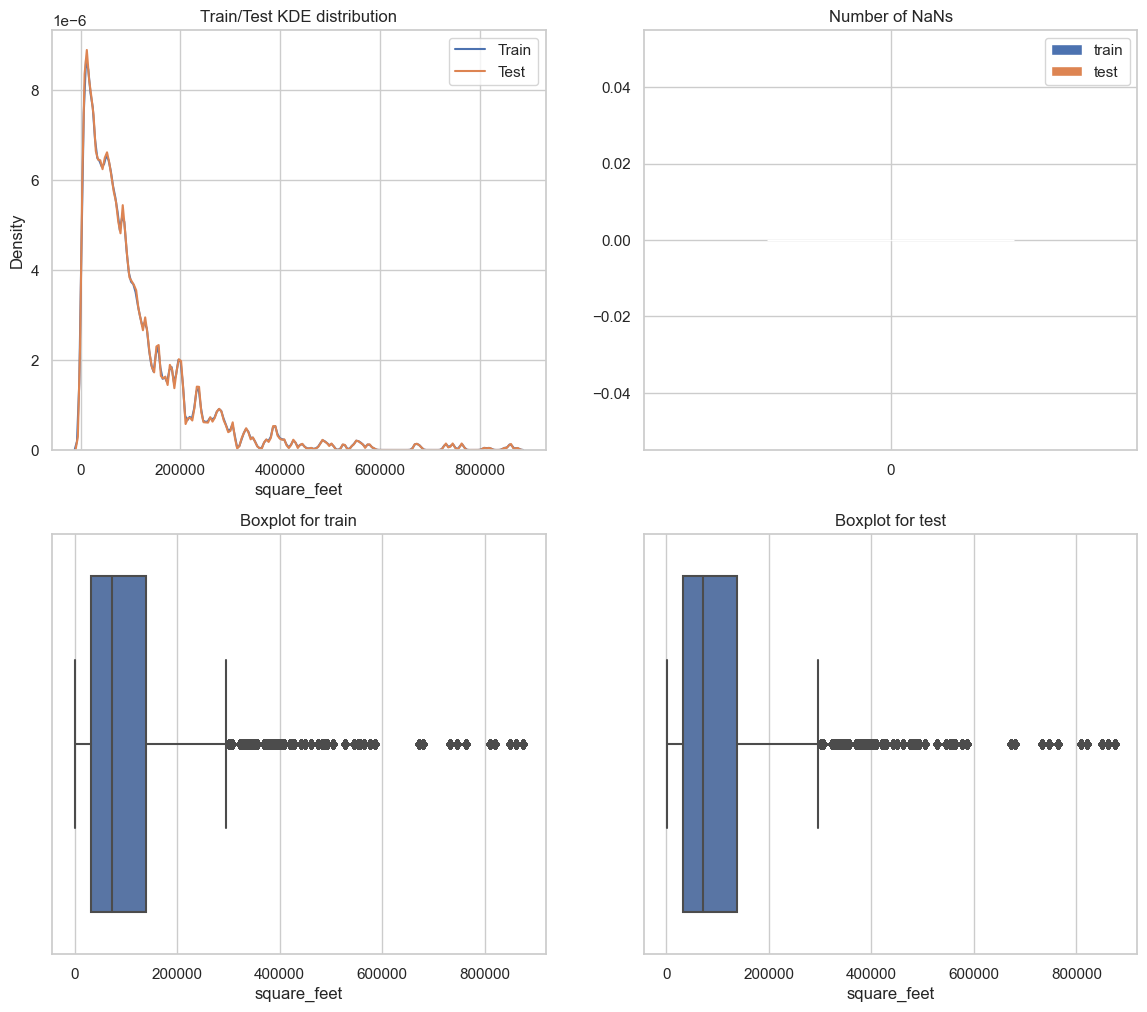

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train_df['square_feet'], ax=axes[0][0], label='Train');
sns.kdeplot(test_df['square_feet'], ax=axes[0][0], label='Test');
sns.boxplot(x=train_df['square_feet'], ax=axes[1][0]);
sns.boxplot(x=test_df['square_feet'], ax=axes[1][1]);
pd.DataFrame({'train': [train_df['square_feet'].isnull().sum()], 'test': [test_df['square_feet'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();

<font size="4">Lets take a look at the mean meter reading by building_id</font>

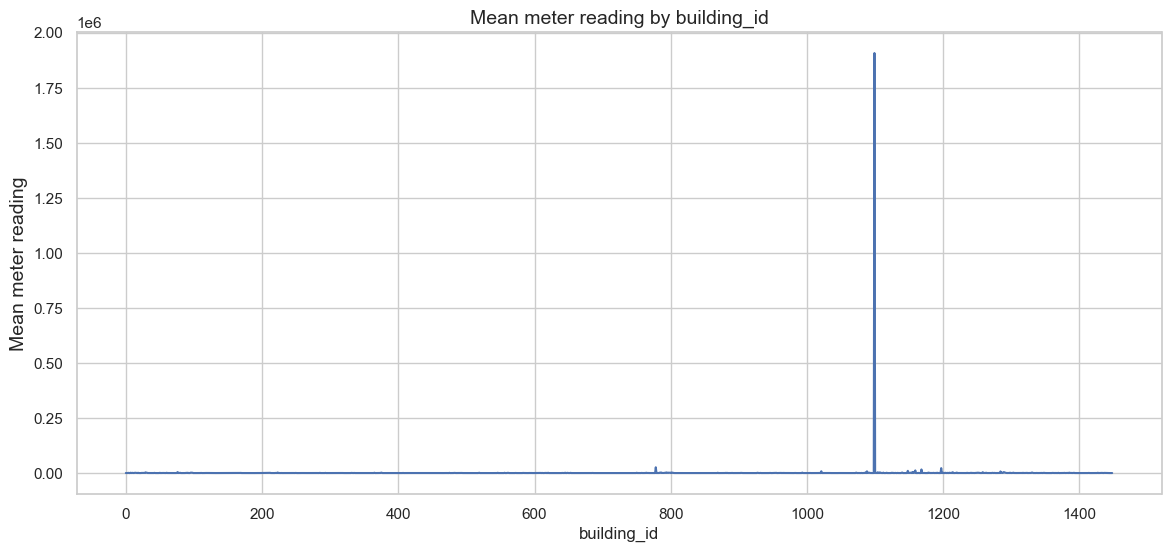

In [64]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

We can conclude that, theres an outlier and since we have already deduced what is causing that. So its building 1089 on site 13 and meter 2. This will be probably an old building with year_built and floor_count not available. Also, we can conclude that this building is using steam for heating. 
Lets explore mean meter reading with site id with and without this building

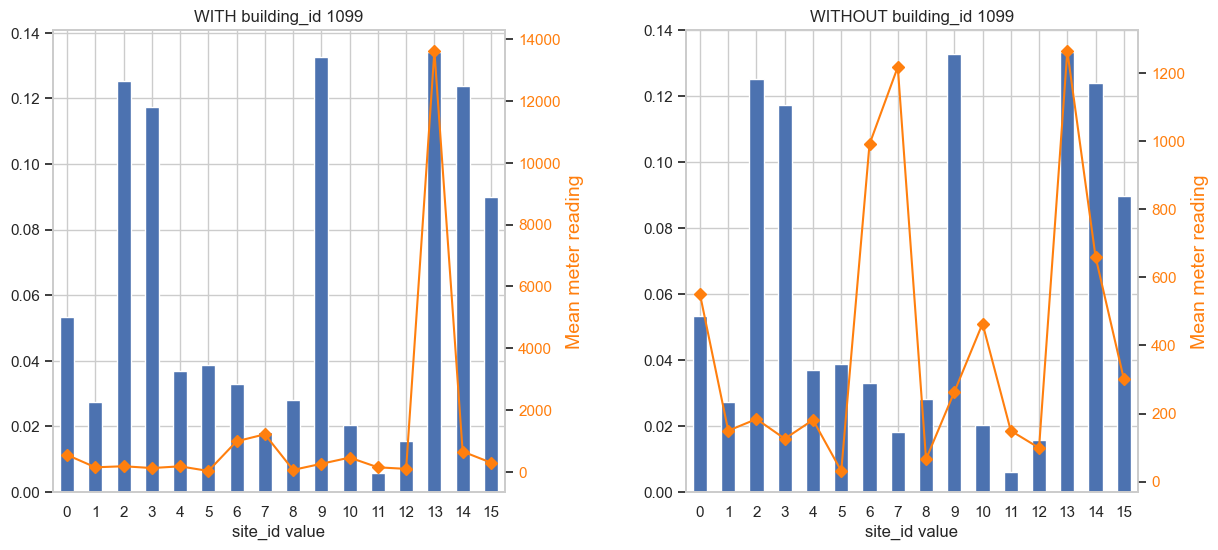

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
train_df['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[0]).set_xlabel('site_id value');
train_df[train_df['building_id']!=1099]['site_id'].value_counts(dropna=False, normalize=True).sort_index().plot(kind='bar', rot=0, ax=axes[1]).set_xlabel('site_id value');
ax2 = axes[0].twinx()
ax3 = axes[1].twinx()
train_df.groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax2, style='D-', grid=False, color='tab:orange');
train_df[train_df['building_id']!=1099].groupby('site_id')['meter_reading'].mean().sort_index().plot(ax=ax3, style='D-', grid=False, color='tab:orange');
ax2.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax3.set_ylabel('Mean meter reading', color='tab:orange', fontsize=14);
ax2.tick_params(axis='y', labelcolor='tab:orange');
ax3.tick_params(axis='y', labelcolor='tab:orange');
plt.subplots_adjust(wspace=0.4)
axes[0].set_title('WITH building_id 1099');
axes[1].set_title('WITHOUT building_id 1099');

### Mean meter reading by building_id wihtout building_id 1099

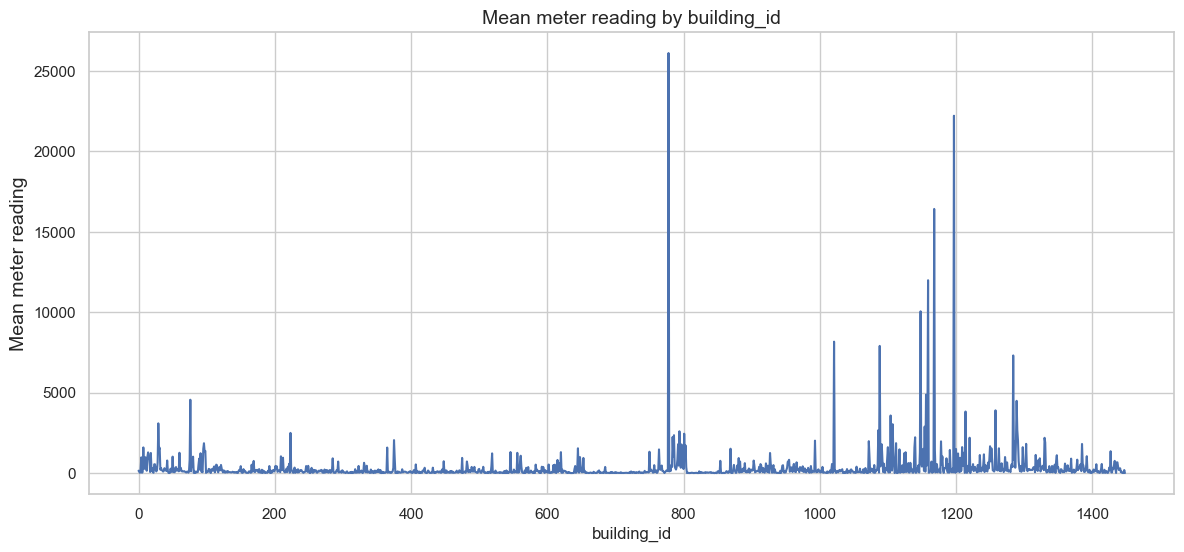

In [66]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df[train_df['building_id'] != 1099].groupby('building_id')['meter_reading'].mean().plot();
axes.set_title('Mean meter reading by building_id', fontsize=14);
axes.set_ylabel('Mean meter reading', fontsize=14);

It is clear that building 1089 is was causing the strange trend.

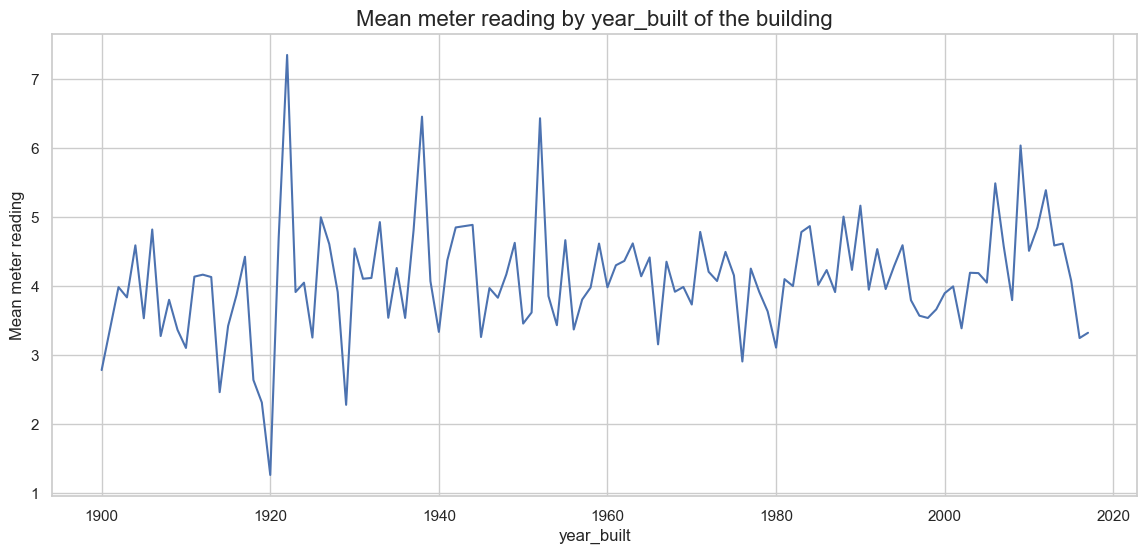

In [207]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


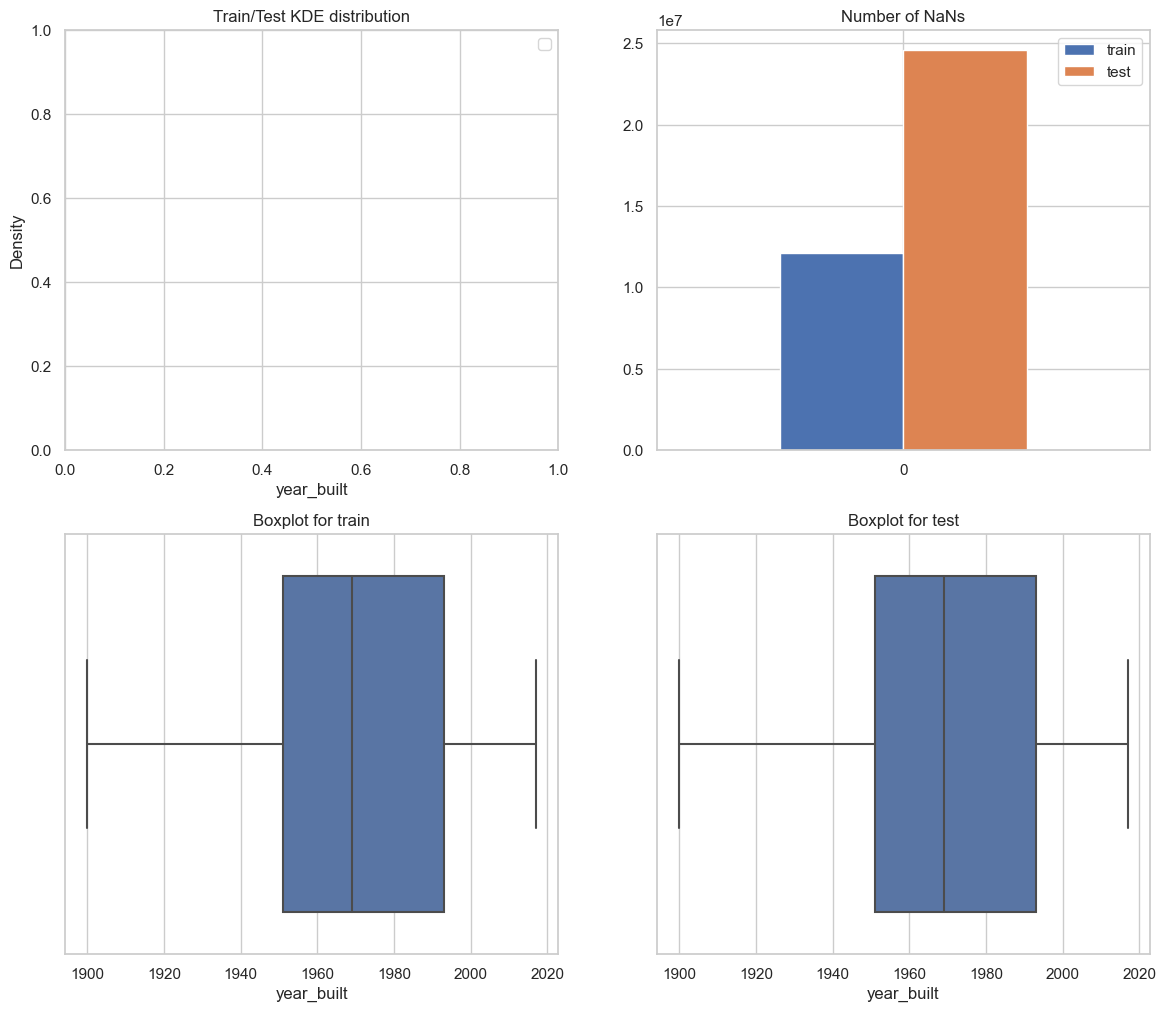

In [208]:


fig, axes = plt.subplots(2, 2, figsize=(14, 12))
sns.kdeplot(train_df['year_built'], ax=axes[0][0], label='Train');
sns.kdeplot(test_df['year_built'], ax=axes[0][0], label='Test');
sns.boxplot(x=train_df['year_built'], ax=axes[1][0]);
sns.boxplot(x=test_df['year_built'], ax=axes[1][1]);
pd.DataFrame({'train': [train_df['year_built'].isnull().sum()], 'test': [test_df['year_built'].isnull().sum()]}).plot(kind='bar', rot=0, ax=axes[0][1]);
axes[0][0].legend();
axes[0][0].set_title('Train/Test KDE distribution');
axes[0][1].set_title('Number of NaNs');
axes[1][0].set_title('Boxplot for train');
axes[1][1].set_title('Boxplot for test');
gc.collect();


CONCLUSION
Approx 60% of missing values for that feature
There is no year built significantly more frequent unless 1976

### Air Temperature

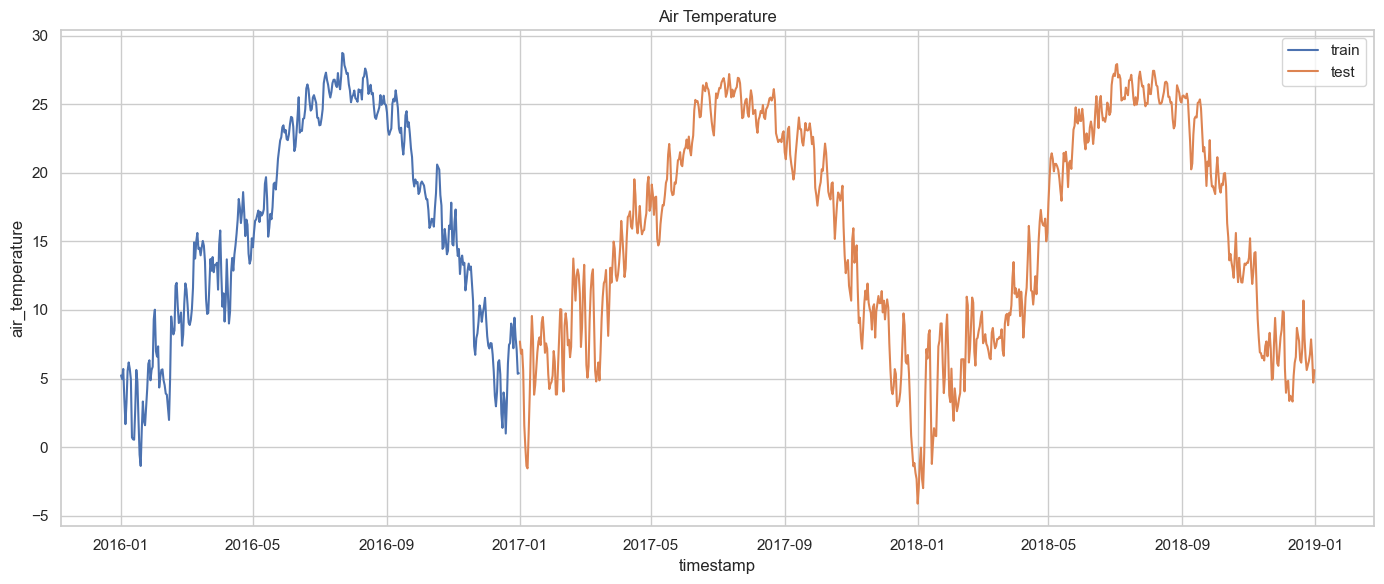

In [209]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_df.set_index('timestamp').resample('D').mean().reset_index(),y='air_temperature',x='timestamp', label='train').set(title='Air Temperature');
sns.lineplot(data=test_df.set_index('timestamp').resample('D').mean().reset_index(),y='air_temperature',x='timestamp', label='test');
plt.tight_layout()

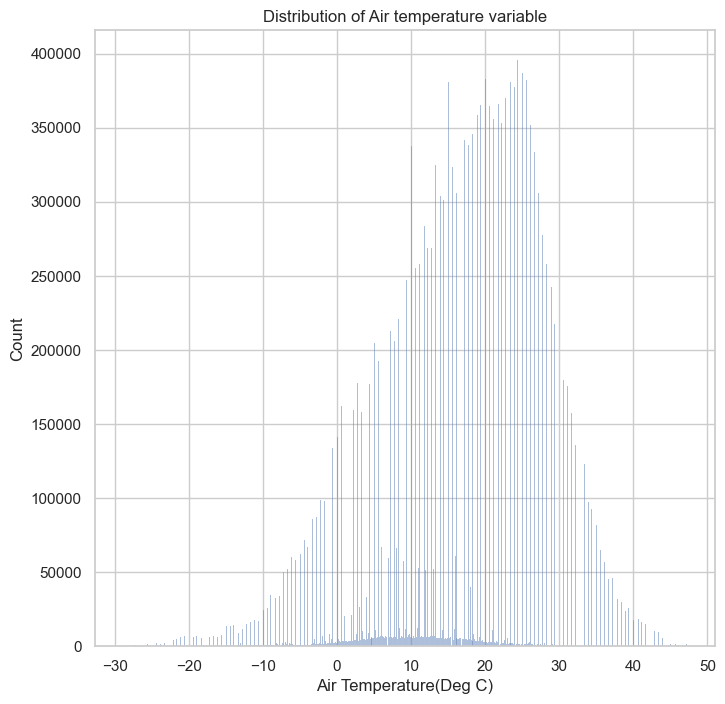

In [69]:
plt.figure(figsize=(8,8))
sns.histplot(train_df['air_temperature'].dropna(), kde=True)
plt.xlabel("Air Temperature(Deg C)")
plt.title("Distribution of Air temperature variable")
plt.show()

The distribution of air temperature is approximately normal, with the highest frequency occurring around 14 degrees Celsius. Most of the recorded temperatures fall within the range of -20 to 40 degrees Celsius.

<font size="4">Floor Count</font>

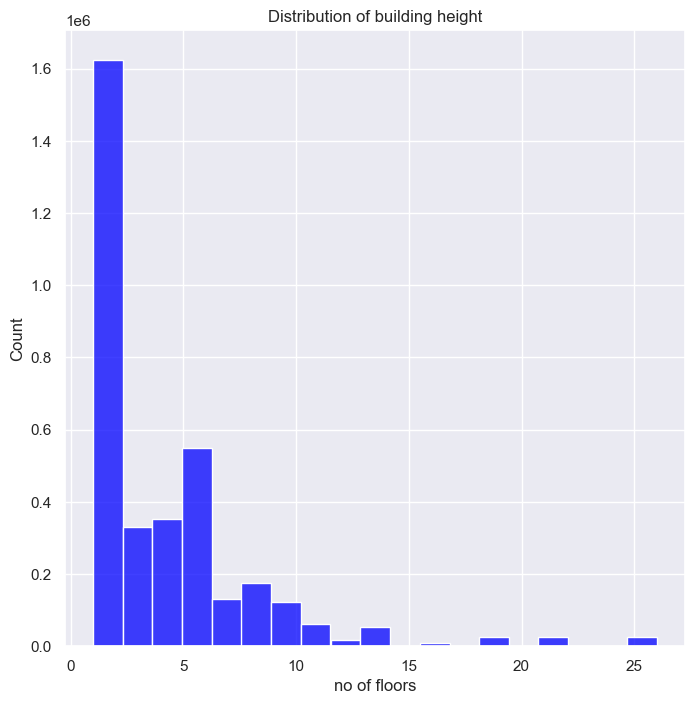

In [210]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
sns.histplot(train_df['floor_count'].dropna(), bins=19 ,color='blue')

plt.xlabel("no of floors")
plt.title("Distribution of building height")
plt.show()

The majority of buildings have fewer than 5 floors, and only a small percentage have more than 10 floors.






### Cloud Coverage

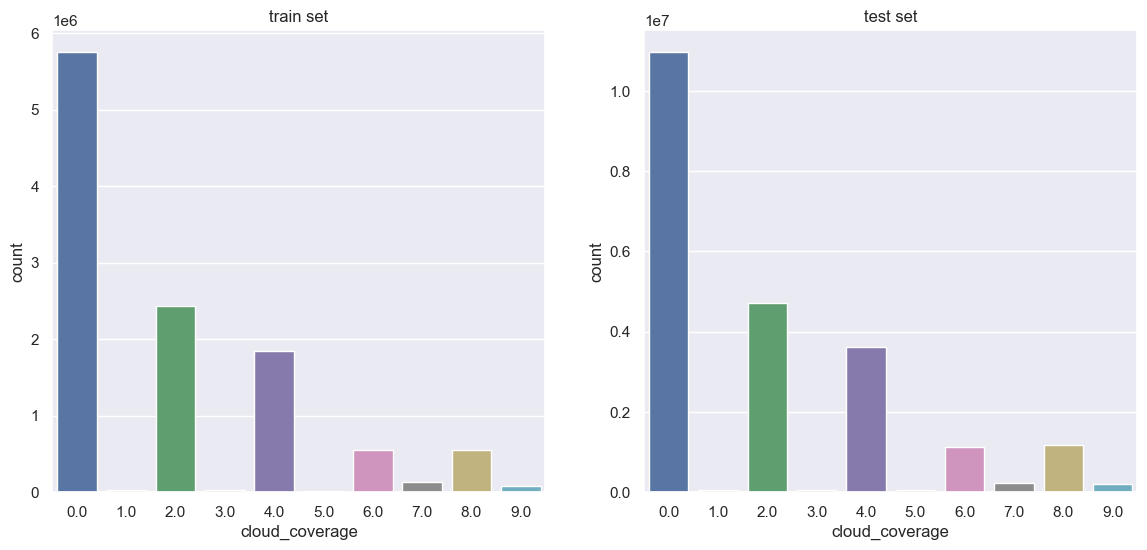

In [211]:
fig, axes = plt.subplots(1,2,figsize=(14, 6))
sns.countplot(data=train_df, x='cloud_coverage',ax=axes[0]).set(title='train set');
sns.countplot(data=test_df, x='cloud_coverage',ax=axes[1]).set(title='test set');

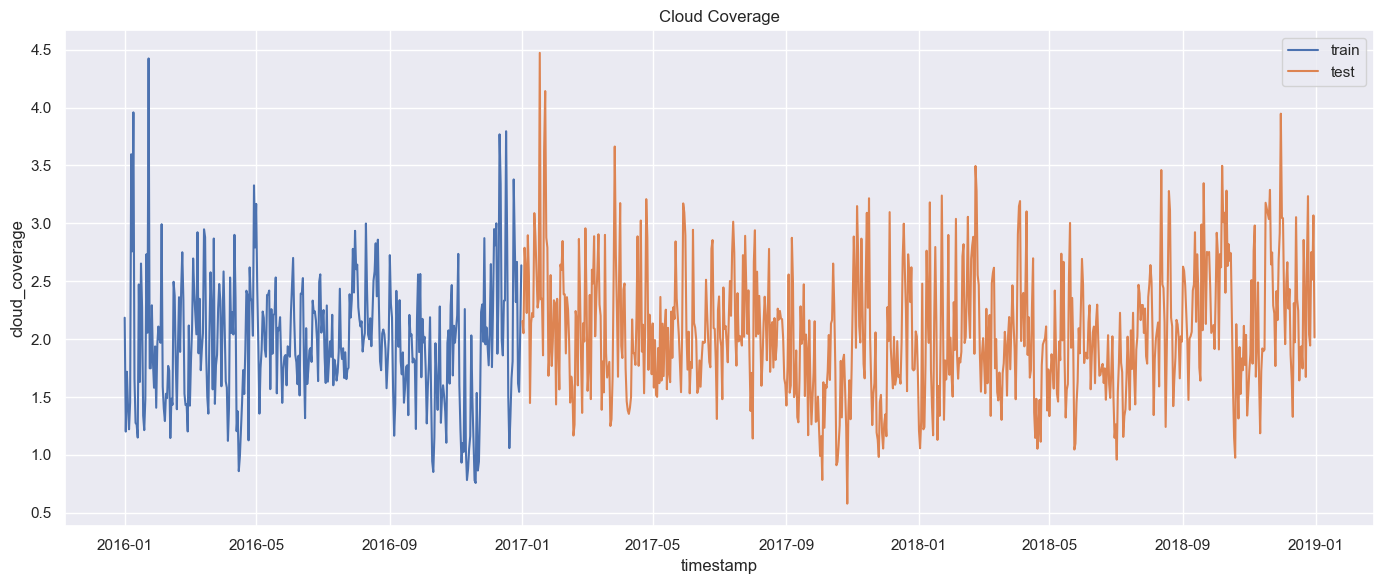

In [212]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_df.set_index('timestamp').resample('D').mean().reset_index(),y='cloud_coverage',x='timestamp', label='train').set(title='Cloud Coverage');
sns.lineplot(data=test_df.set_index('timestamp').resample('D').mean().reset_index(),y='cloud_coverage',x='timestamp', label='test');
plt.tight_layout()

we can conclude that appox. 46% of missing values the same distribution and trend between train and test set.

### Dew temperature

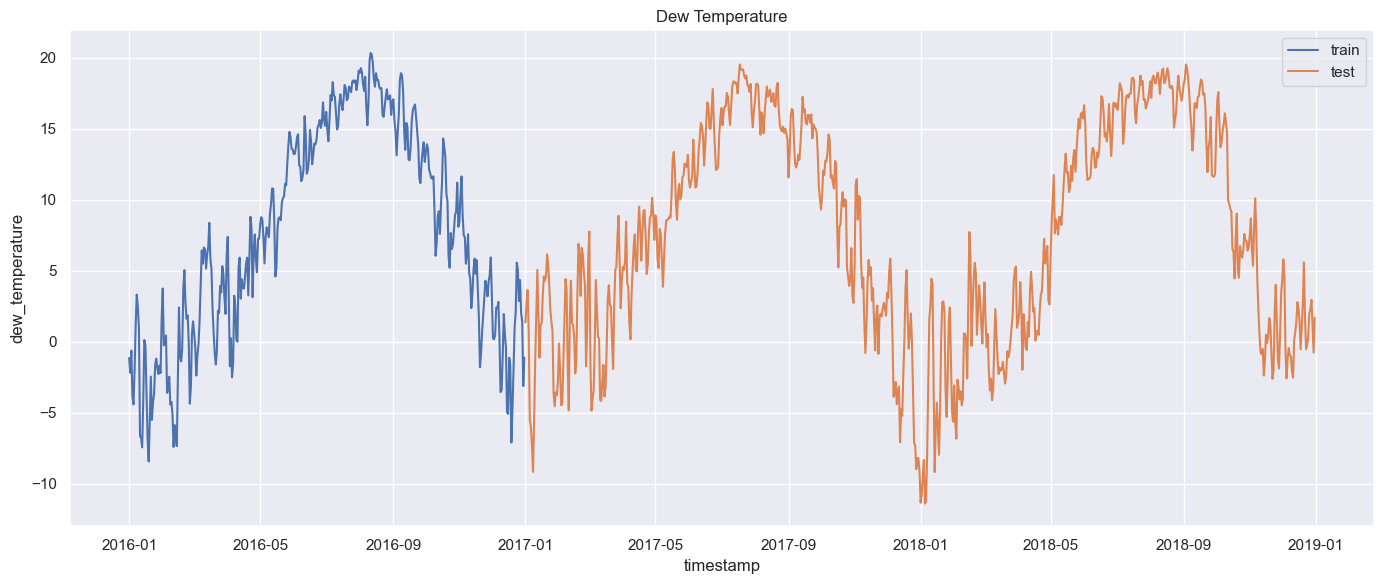

In [213]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_df.set_index('timestamp').resample('D').mean().reset_index(),y='dew_temperature',x='timestamp', label='train').set(title='Dew Temperature');
sns.lineplot(data=test_df.set_index('timestamp').resample('D').mean().reset_index(),y='dew_temperature',x='timestamp', label='test');
plt.tight_layout()

Here we can see the same seasonality for both train and test sets

### Year Built

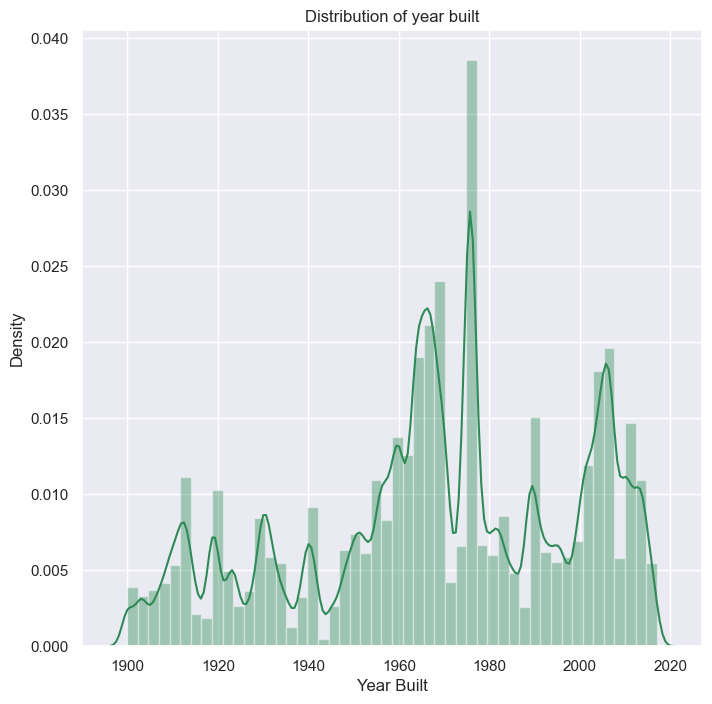

In [214]:
plt.figure(figsize=(8,8))
sns.distplot(train_df['year_built'].dropna(), color='Seagreen')
plt.xlabel("Year Built")
plt.title("Distribution of year built")
plt.show()

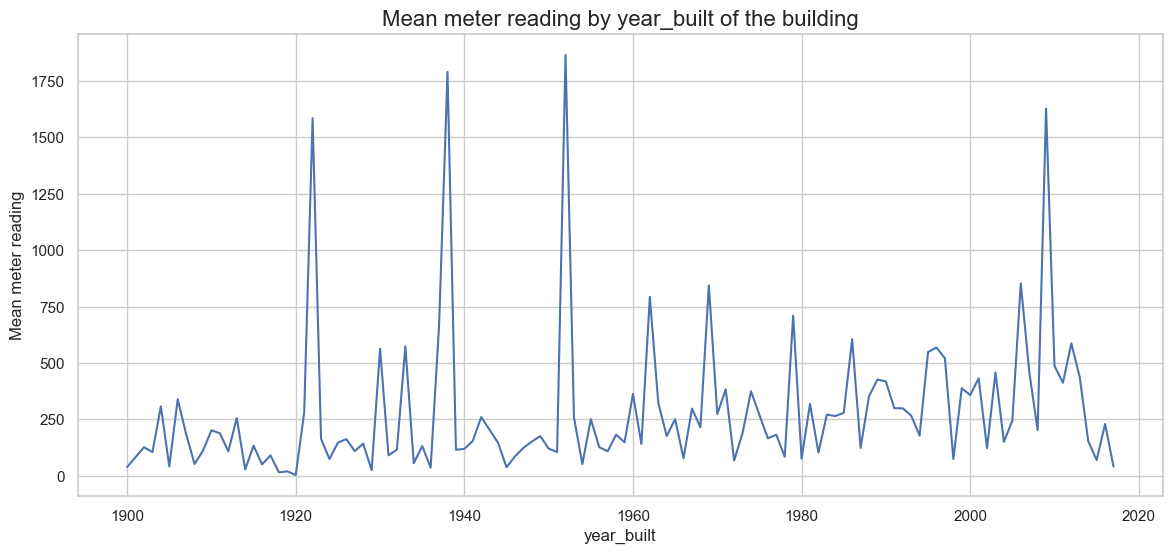

In [67]:
fig, axes = plt.subplots(1,1,figsize=(14, 6))
train_df.groupby('year_built')['meter_reading'].mean().plot().set_ylabel('Mean meter reading');
axes.set_title('Mean meter reading by year_built of the building', fontsize=16);

The distribution of building construction dates spans approximately 120 years. The majority of buildings were constructed after 1960, with a peak around 1975.






### Precipitation Depth 1 hour

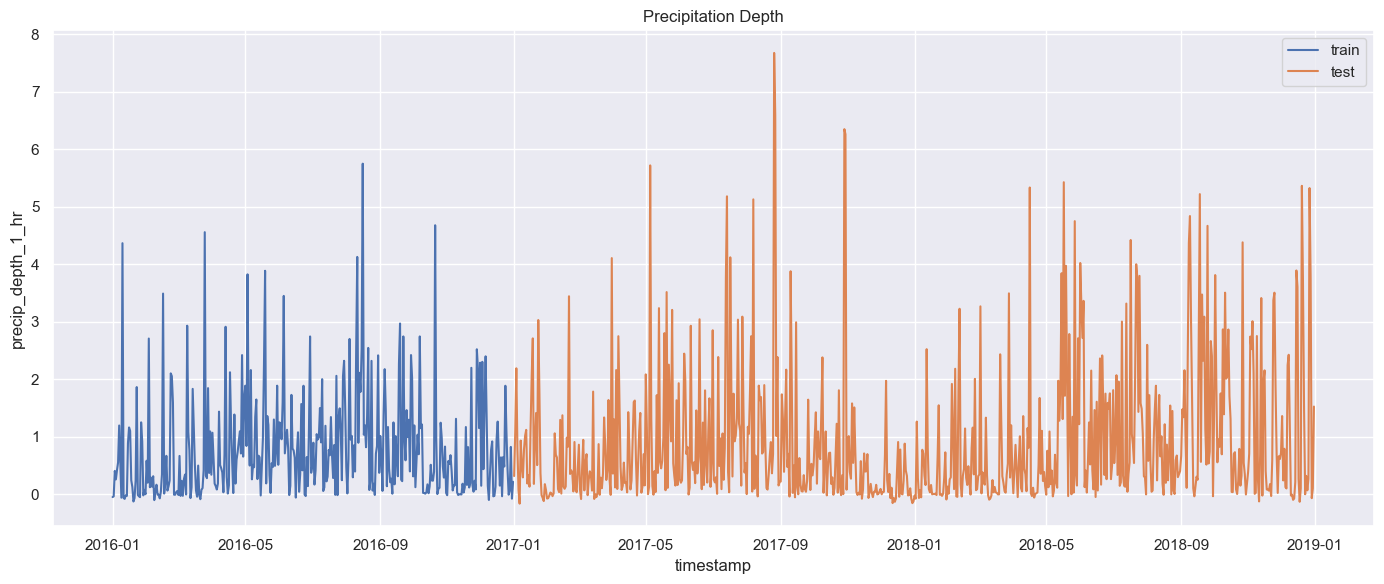

In [215]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_df.set_index('timestamp').resample('D').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='train').set(title='Precipitation Depth');
sns.lineplot(data=test_df.set_index('timestamp').resample('D').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='test');
plt.tight_layout()

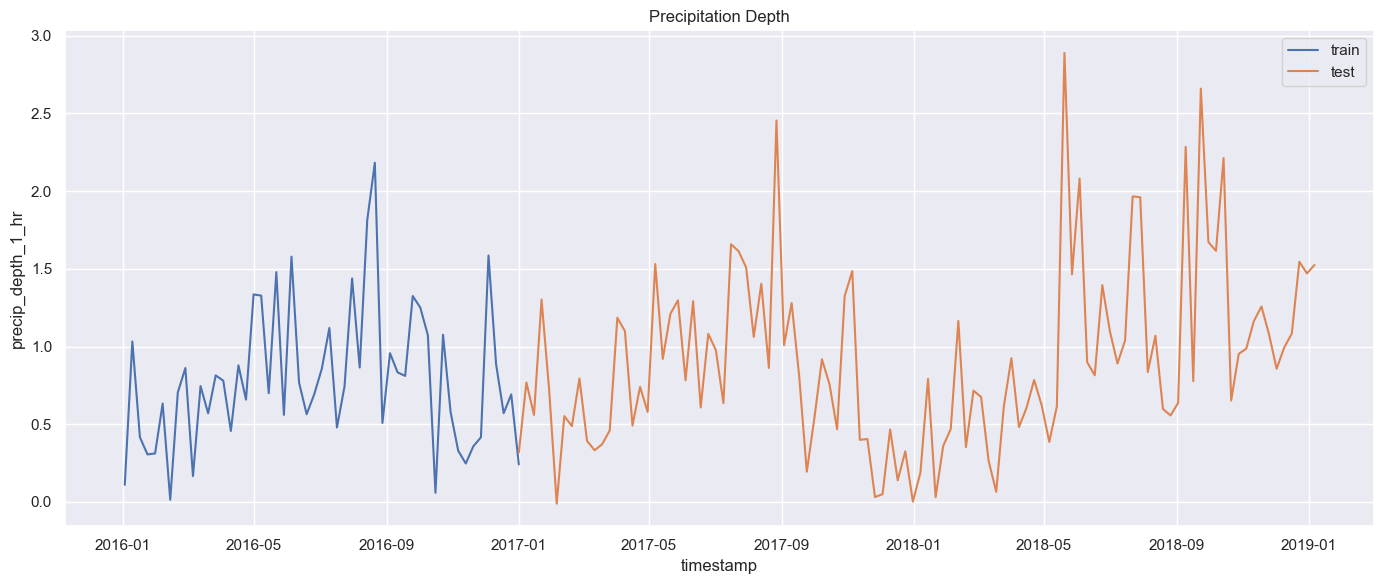

In [216]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_df.set_index('timestamp').resample('W').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='train').set(title='Precipitation Depth');
sns.lineplot(data=test_df.set_index('timestamp').resample('W').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='test');
plt.tight_layout()

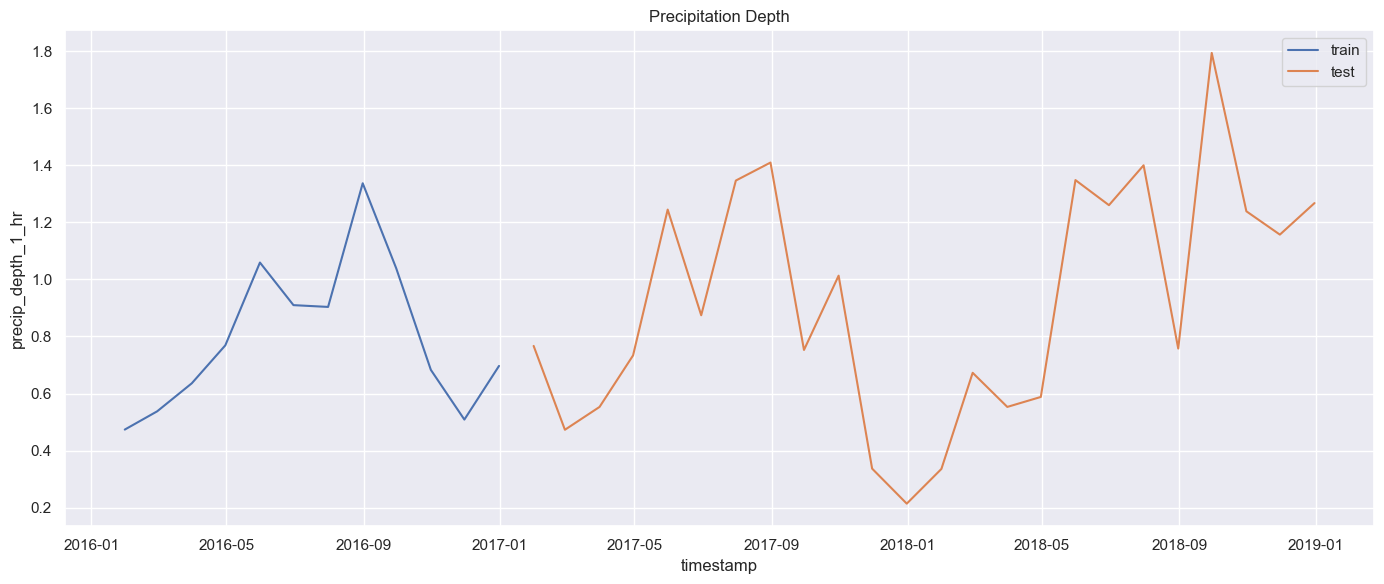

In [217]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_df.set_index('timestamp').resample('M').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='train').set(title='Precipitation Depth');
sns.lineplot(data=test_df.set_index('timestamp').resample('M').mean().reset_index(),y='precip_depth_1_hr',x='timestamp', label='test');
plt.tight_layout()

We can observe the same seasonality between 2016 and 2017 but a greater precipitation depth for late 2018

### Sea Level Pressure

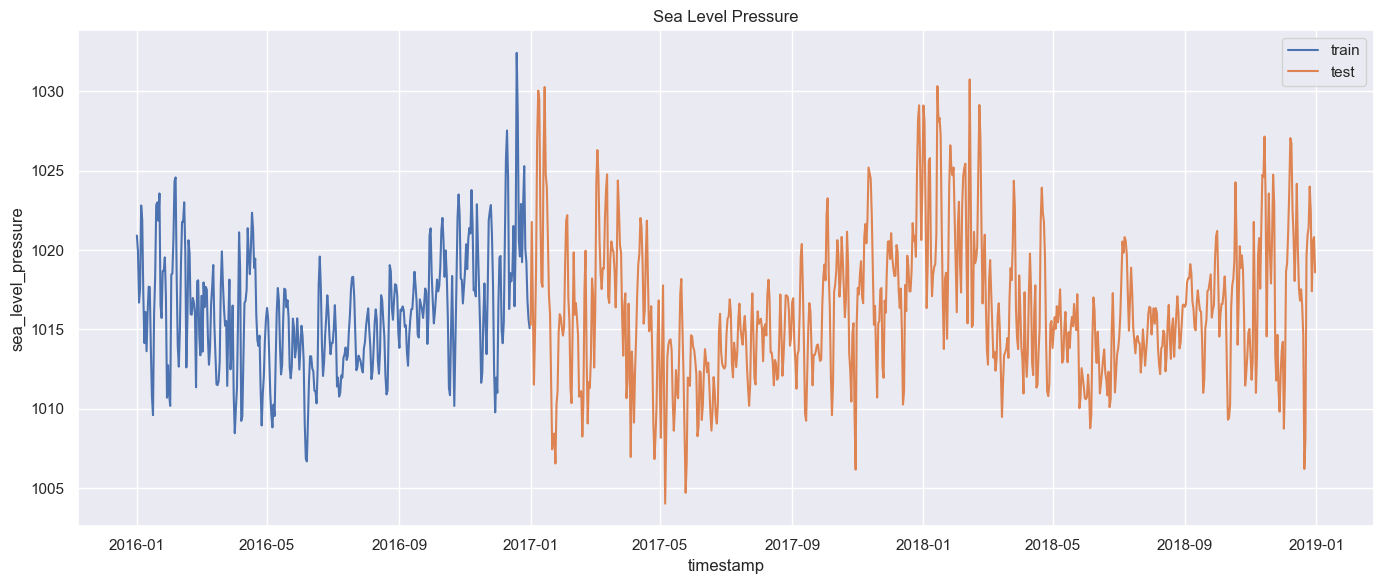

In [218]:
fig,axes = plt.subplots(1,1,figsize=(14, 6))
sns.lineplot(data=train_df.set_index('timestamp').resample('D').mean().reset_index(),y='sea_level_pressure',x='timestamp', label='train').set(title='Sea Level Pressure');
sns.lineplot(data=test_df.set_index('timestamp').resample('D').mean().reset_index(),y='sea_level_pressure',x='timestamp', label='test');
plt.tight_layout()

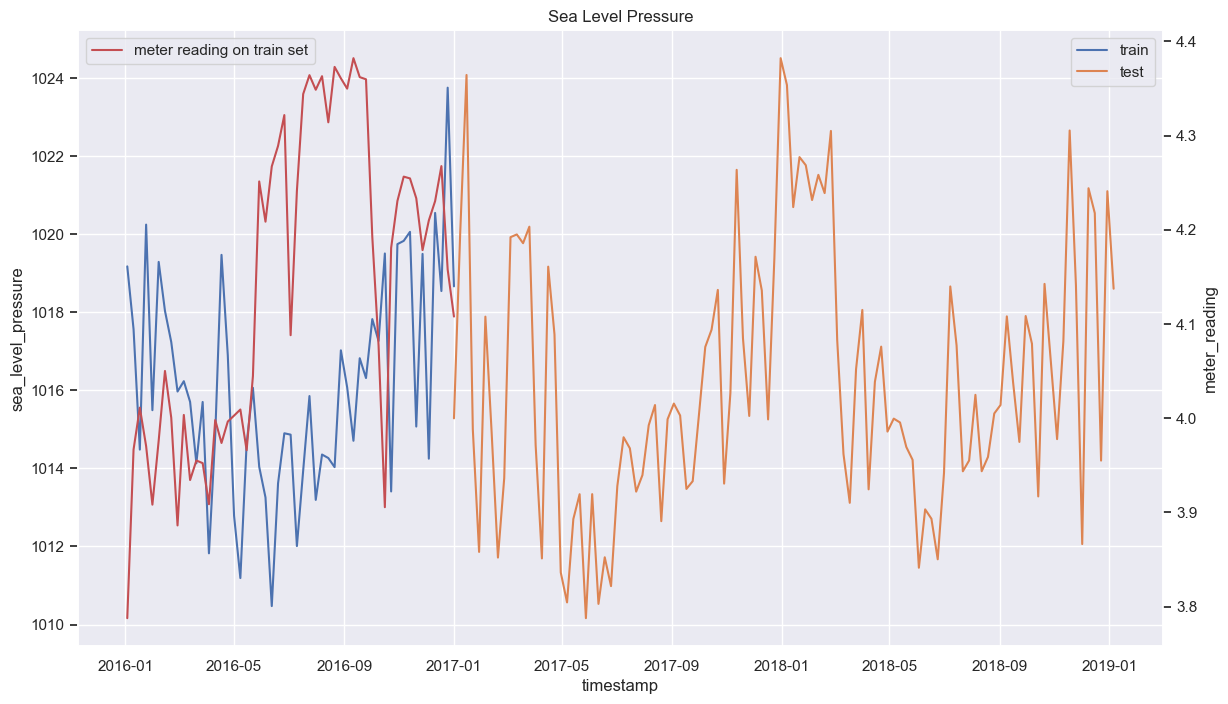

In [219]:
fig,axes = plt.subplots(1,1,figsize=(14, 8))
tr = sns.lineplot(data=train_df.set_index('timestamp').resample('W').mean().reset_index(),y='sea_level_pressure',x='timestamp', label='train').set(title='Sea Level Pressure');
tt = sns.lineplot(data=test_df.set_index('timestamp').resample('W').mean().reset_index(),y='sea_level_pressure',x='timestamp', label='test');
ax2 = axes.twinx()
ax2.grid(False);
mr = sns.lineplot(data=train_df.set_index('timestamp').resample('W').mean().reset_index(),y='meter_reading',x='timestamp', color='r', label='meter reading on train set');
axes.legend(loc=0);
ax2.legend(loc=2);

To conclude, the same seasonality for both train and test sets and there is positive correlation between sea level pressure and meter reading

## Wind Direction & Wind Speed

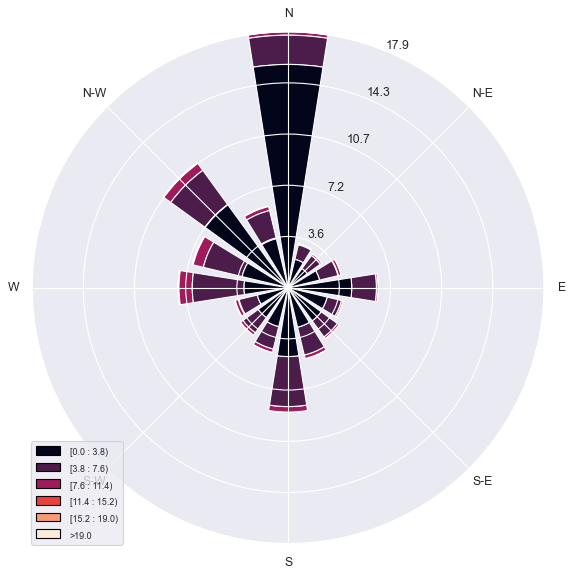

In [233]:

wind_df = train_df.loc[:,['wind_direction','wind_speed']].dropna()
ax = WindroseAxes.from_ax()

# Create a color map with vibrant colors
cmap = cm.get_cmap('tab20c')

# Get the number of unique wind directions
num_directions = len(wind_df['wind_direction'].unique())

# Generate a list of colors from the color map
colors = [cmap(i) for i in range(num_directions)]

# Plot the windrose with the new color scheme
ax.bar(wind_df['wind_direction'], wind_df['wind_speed'], normed=True, opening=0.8, facecolor=colors, edgecolor='white')
ax.set_legend()

Based on the windrose diagram provided, it can be observed that the predominant direction from which the wind blows across the various locations is towards the East at an angle of 90 degrees. The second most common direction of wind flow is towards the West at an angle of 270 degrees. Additionally, it can be seen that the wind speed typically falls between the range of 0 to 11.4 m/s, regardless of the direction from which the wind is blowing.

# T-2 Data Preparation & Preprocessing

Reference: Unit Correction For Site 0 Meter Readings
https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261

In [234]:
train_df.loc[(train_df['site_id'] == 0) & (train_df['meter'] ==0),'meter_reading'] = train_df['meter_reading']*0.2931
print("Converted model inputs into kWh for site 0 meter 0 like the other sites to make the data consistent.")

Converted model inputs into kWh for site 0 meter 0 like the other sites to make the data consistent.


### Unique Values By Site ID For The Following Columns
- cloud_coverage
- precip_depth_1_hr
- wind_direction
- sea_level_pressure
- wind_speed
- dew_temperature
- air_temperature

In [235]:
# Find unique values for selected features for each site ID
cloud_coverage_unique_values=train_df.groupby('site_id')['cloud_coverage'].apply(lambda x: list(np.unique(x)))
print("Unique Values For 'cloud_coverage' For Each Site ID")
print(cloud_coverage_unique_values)

precip_depth_1_hr_unique_values=train_df.groupby('site_id')['precip_depth_1_hr'].apply(lambda x: list(np.unique(x)))
print("Unique Values For 'precip_depth_1_hr' For Each Site ID")
print(precip_depth_1_hr_unique_values)

wind_direction_unique_values=train_df.groupby('site_id')['wind_direction'].apply(lambda x: list(np.unique(x)))
print("Unique Values For 'wind_direction' For Each Site ID")
print(wind_direction_unique_values)

sea_level_pressure_unique_values=train_df.groupby('site_id')['sea_level_pressure'].apply(lambda x: list(np.unique(x)))
print("Unique Values For 'sea_level_pressure' For Each Site ID")
print(sea_level_pressure_unique_values)

wind_speed_unique_values=train_df.groupby('site_id')['wind_speed'].apply(lambda x: list(np.unique(x)))
print("Unique Values For 'wind_speed' For Each Site ID")
print(wind_speed_unique_values)

dew_temperature_unique_values=train_df.groupby('site_id')['dew_temperature'].apply(lambda x: list(np.unique(x)))
print("Unique Values For 'dew_temperature' For Each Site ID")
print(dew_temperature_unique_values)

air_temperature_unique_values=train_df.groupby('site_id')['air_temperature'].apply(lambda x: list(np.unique(x)))
print("Unique Values For 'air_temperature' For Each Site ID")
print(air_temperature_unique_values)


Unique Values For 'cloud_coverage' For Each Site ID
site_id
0                    [0.0, 2.0, 4.0, 6.0, 8.0, 9.0]
1                                        [0.0, 9.0]
2                    [0.0, 2.0, 4.0, 6.0, 8.0, 9.0]
3                    [0.0, 2.0, 4.0, 6.0, 8.0, 9.0]
4                              [0.0, 2.0, 4.0, 9.0]
5                                        [0.0, 9.0]
6                              [0.0, 2.0, 4.0, 9.0]
7                                             [0.0]
8                    [0.0, 2.0, 4.0, 6.0, 8.0, 9.0]
9                              [0.0, 2.0, 4.0, 9.0]
10                             [0.0, 2.0, 4.0, 9.0]
11                                            [0.0]
12    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
13                   [0.0, 2.0, 4.0, 6.0, 8.0, 9.0]
14                             [0.0, 2.0, 4.0, 9.0]
15                             [0.0, 2.0, 4.0, 9.0]
Name: cloud_coverage, dtype: object
Unique Values For 'precip_depth_1_hr' For Each Site ID
site_id
0     [-1

 ### Handling Missing Values

In [236]:
year_built_gp = train_df.groupby('site_id')['year_built']
train_df['year_built'] = year_built_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).mean())))
train_df['year_built'].fillna(np.floor(np.nanmean(train_df['year_built'].astype(float))), inplace=True)

floor_count_gp = train_df.groupby('primary_use')['floor_count']
train_df['floor_count'] = floor_count_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).mean())))
train_df['floor_count'].fillna(np.floor(np.nanmean(train_df['floor_count'].astype(float))), inplace=True)
assert pd.isnull(train_df['floor_count']).sum() == 0

cloud_coverage_gp = train_df.groupby('site_id')['cloud_coverage']
train_df['cloud_coverage'] = cloud_coverage_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
train_df['cloud_coverage'].fillna(np.floor(np.nanpercentile(train_df['cloud_coverage'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(train_df['cloud_coverage']).sum() == 0

precip_depth_1_hr_gp = train_df.groupby('site_id')['precip_depth_1_hr']
train_df['precip_depth_1_hr'] = precip_depth_1_hr_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
train_df['precip_depth_1_hr'].fillna(np.floor(np.nanpercentile(train_df['precip_depth_1_hr'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(train_df['precip_depth_1_hr']).sum() == 0

wind_direction_gp = train_df.groupby('site_id')['wind_direction']
train_df['wind_direction'] = wind_direction_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
train_df['wind_direction'].fillna(np.floor(np.nanpercentile(train_df['wind_direction'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(train_df['wind_direction']).sum() == 0

sea_level_pressure_gp = train_df.groupby('site_id')['sea_level_pressure']
train_df['sea_level_pressure'] = sea_level_pressure_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
train_df['sea_level_pressure'].fillna(np.floor(np.nanpercentile(train_df['sea_level_pressure'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(train_df['sea_level_pressure']).sum() == 0

wind_speed_gp = train_df.groupby('site_id')['wind_speed']
train_df['wind_speed'] = wind_speed_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
train_df['wind_speed'].fillna(np.floor(np.nanpercentile(train_df['wind_speed'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(train_df['wind_speed']).sum() == 0

dew_temperature_gp = train_df.groupby('site_id')['dew_temperature']
train_df['dew_temperature'] = dew_temperature_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
train_df['dew_temperature'].fillna(np.floor(np.nanpercentile(train_df['dew_temperature'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(train_df['dew_temperature']).sum() == 0

air_temperature_gp = train_df.groupby('site_id')['air_temperature']
train_df['air_temperature'] = air_temperature_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
train_df['air_temperature'].fillna(np.floor(np.nanpercentile(train_df['air_temperature'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(train_df['air_temperature']).sum() == 0


print("Null Values Computed")

Null Values Computed


### Recheck Null Values

In [237]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data

Total  Percent
building_id             0      0.0
meter                   0      0.0
meter__2                0      0.0
meter__1                0      0.0
meter__0                0      0.0
day                     0      0.0
hour                    0      0.0
weekday                 0      0.0
month                   0      0.0
wind_speed              0      0.0
wind_direction          0      0.0
sea_level_pressure      0      0.0
precip_depth_1_hr       0      0.0
dew_temperature         0      0.0
cloud_coverage          0      0.0
air_temperature         0      0.0
floor_count             0      0.0
year_built              0      0.0
square_feet             0      0.0
primary_use             0      0.0
site_id                 0      0.0
meter_reading           0      0.0
timestamp               0      0.0
meter__3                0      0.0

Computing missing values for test set

In [238]:
year_built_gp = test_df.groupby('site_id')['year_built']
test_df['year_built'] = year_built_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).mean())))
test_df['year_built'].fillna(np.floor(np.nanmean(test_df['year_built'].astype(float))), inplace=True)

floor_count_gp = test_df.groupby('primary_use')['floor_count']
test_df['floor_count'] = floor_count_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).mean())))
test_df['floor_count'].fillna(np.floor(np.nanmean(test_df['floor_count'].astype(float))), inplace=True)
assert pd.isnull(test_df['floor_count']).sum() == 0

cloud_coverage_gp = test_df.groupby('site_id')['cloud_coverage']
test_df['cloud_coverage'] = cloud_coverage_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
test_df['cloud_coverage'].fillna(np.floor(np.nanpercentile(test_df['cloud_coverage'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(test_df['cloud_coverage']).sum() == 0

precip_depth_1_hr_gp = test_df.groupby('site_id')['precip_depth_1_hr']
test_df['precip_depth_1_hr'] = precip_depth_1_hr_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
test_df['precip_depth_1_hr'].fillna(np.floor(np.nanpercentile(test_df['precip_depth_1_hr'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(test_df['precip_depth_1_hr']).sum() == 0

wind_direction_gp = test_df.groupby('site_id')['wind_direction']
test_df['wind_direction'] = wind_direction_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
test_df['wind_direction'].fillna(np.floor(np.nanpercentile(test_df['wind_direction'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(test_df['wind_direction']).sum() == 0

sea_level_pressure_gp = test_df.groupby('site_id')['sea_level_pressure']
test_df['sea_level_pressure'] = sea_level_pressure_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
test_df['sea_level_pressure'].fillna(np.floor(np.nanpercentile(test_df['sea_level_pressure'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(test_df['sea_level_pressure']).sum() == 0

wind_speed_gp = test_df.groupby('site_id')['wind_speed']
test_df['wind_speed'] = wind_speed_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
test_df['wind_speed'].fillna(np.floor(np.nanpercentile(test_df['wind_speed'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(test_df['wind_speed']).sum() == 0

dew_temperature_gp = test_df.groupby('site_id')['dew_temperature']
test_df['dew_temperature'] = dew_temperature_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
test_df['dew_temperature'].fillna(np.floor(np.nanpercentile(test_df['dew_temperature'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(test_df['dew_temperature']).sum() == 0

air_temperature_gp = test_df.groupby('site_id')['air_temperature']
test_df['air_temperature'] = air_temperature_gp.transform(lambda x: x.fillna(np.floor(x.astype(float).quantile(q=0.9))))
test_df['air_temperature'].fillna(np.floor(np.nanpercentile(test_df['air_temperature'].astype(float),q=0.9)), inplace=True)
assert pd.isnull(test_df['air_temperature']).sum() == 0


print("Null Values Computed")

Null Values Computed


In [226]:
total_t = test_df.isnull().sum().sort_values(ascending = False)
percent_t = (test_df.isnull().sum()/test_df.isnull().count()*100).sort_values(ascending = False)
missing_test_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test_data

Total  Percent
building_id             0      0.0
meter                   0      0.0
meter__2                0      0.0
meter__1                0      0.0
meter__0                0      0.0
day                     0      0.0
hour                    0      0.0
weekday                 0      0.0
month                   0      0.0
wind_speed              0      0.0
wind_direction          0      0.0
sea_level_pressure      0      0.0
precip_depth_1_hr       0      0.0
dew_temperature         0      0.0
cloud_coverage          0      0.0
air_temperature         0      0.0
floor_count             0      0.0
year_built              0      0.0
square_feet             0      0.0
primary_use             0      0.0
site_id                 0      0.0
meter_reading           0      0.0
timestamp               0      0.0
meter__3                0      0.0

In [ ]:
test_df.drop('row_id', axis=1, inplace=True)

In [240]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

features_label = ['building_id', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'meter', 'month', 'weekday',
       'hour', 'day']

numerical_features = ['square_feet',
       'year_built', 'floor_count', 'air_temperature',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed']

categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday", "month", "cloud_coverage"]

# Sort Data by Timestamp
train_df.sort_values('timestamp', inplace=True)
train_df.reset_index(drop=True, inplace=True)


# Label Encode Primary Use
le = LabelEncoder()
train_df['primary_use'] = le.fit_transform(train_df['primary_use'])

In [241]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler


test = 'OK' # Apply feature engineering to test set
logscale = True # Apply log scale


if test is not None:
    test_df['primary_use'] = le.transform(test_df['primary_use'])


# Extract information from timestamp
train_df['month'] = train_df['timestamp'].dt.month
train_df['weekday'] = train_df['timestamp'].dt.weekday
train_df['hour'] = train_df['timestamp'].dt.hour
train_df['day'] = train_df['timestamp'].dt.day

if test is not None:
    test_df['month'] = test_df['timestamp'].dt.month
    test_df['weekday'] = test_df['timestamp'].dt.weekday
    test_df['hour'] = test_df['timestamp'].dt.hour
    test_df['day'] = test_df['timestamp'].dt.day
 
     


if logscale:
    train_df['square_feet'] = np.log1p(train_df['square_feet'])
    train_df['meter_reading'] = np.log1p(train_df['meter_reading'])

    if test is not None:
        test_df['square_feet'] = np.log1p(test_df['square_feet'])
       

else:

    scaler = MinMaxScaler()
    train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
    y_scaler = MinMaxScaler()
    train_df['meter_reading'] = y_scaler.fit_transform(train_df[['meter_reading']])
    if test is not None:
        test_df[numerical_features] = scaler.transform(test_df[numerical_features])



X = train_df[features_label]
y = train_df[['meter_reading']]
if test is not None:
    X_test = test_df[features_label]
    

gc.collect()

KeyboardInterrupt: 

## Outlier Treatment

#### We cocnluded from EDA that building 1099 was a strong outlier and removing it is essential for model performance

In [ ]:
drop_indices= list(train_df[train_df['building_id']==1099].index)
train_df.drop(drop_indices, axis=0, inplace=True)

In [ ]:
# After drop building 1099, should we drop 778?
plt.figure(figsize = (6,6))
site_df= train_df.groupby(['building_id']).meter_reading.mean().reset_index()
sns.lineplot(x=site_df['building_id'], y=site_df['meter_reading'], color='purple')
plt.ylabel("Average Meter readings")
plt.xlabel("Building IDs")
plt.title("Buildingwise Average Consumption")
plt.show()

### Saving Processed Dataset

In [ ]:
X.to_csv('processed_train_X.csv')
y.to_csv('processed_train_y.csv')
X_test.to_csv('processed_test_X.csv')

# T-3 Model Implementation and Hyperparameter tuning

## Light- GBM

In [17]:
from hyperopt import hp
import hyperopt.pyll.stochastic
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.model_selection  import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [3]:
# Loading in processed datasets
X = pd.read_csv('processed_train_X.csv').iloc[:-1, 1:]
y = (pd.read_csv('processed_train_y.csv').iloc[:-1, -1])
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('processed_test_X.csv').iloc[:-1, 1:]
test = test.append(test.iloc[-1], ignore_index=True)

In [23]:
x_train, x_val, y_train, y_val = train_test_split(X ,y, test_size = 0.2, random_state= 25)

In [24]:
#Defining paramaters to be iterated over
parameter_bounds = {
    'learning_rate': (0.002, 0.35),
    'num_leaves': (30, 600), 
    'bagging_fraction' : (0.1, 1),
    'feature_fraction' : (0.1, 1),
}

In [25]:
def lgbm_optimise(learning_rate, 
                num_leaves,
                bagging_fraction, 
                feature_fraction, ):
    
    params = {'learning_rate': learning_rate,
              'num_leaves': int(num_leaves), 
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'objective': 'regression',
              'boosting_type': 'gbdt',
              'random_state': 47,
              'verbosity': 0,
              'metric': 'rmse'}
    
    train_data = lgb.Dataset(x_train, y_train)
    validation_data = lgb.Dataset(x_val, y_val)
    model = lgb.train(params, train_data, 5000, valid_sets = [train_data, validation_data], verbose_eval=0, early_stopping_rounds=50)
    # Returning negative rmse because optimizer tries to maximize a function
    return -model.best_score['valid_1']['rmse']

In [26]:
# Finding hyperparameters using bayesian optimization
optimizer = BayesianOptimization(f=lgbm_optimise, pbounds=parameter_bounds, random_state=47)
optimizer.maximize(init_points=10, n_iter=5)

|   iter    |  target   | baggin... | featur... | learni... | num_le... |
-------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
| 1         | -0.4587   | 0.2021    | 0.977     | 0.2189    | 230.3     |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.790828 seconds.
You can set `force_col_wise=true` to remove the overhead.
| 2         | -0.4657   | 0.7368    | 0.8196    | 0.194     | 266.3     |
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
| 3         | -0.8122   | 0.7354    | 0.322     | 0.07754   | 43.69     |
[LightG

In [27]:
print(optimizer.max['params'])

{'bagging_fraction': 0.10954184761059377, 'feature_fraction': 0.8954206460130215, 'learning_rate': 0.19726678378891035, 'num_leaves': 567.0859044089582}


In [29]:
opti_params = {'learning_rate': 0.19726678378891035,
              'num_leaves': int(567), 
              'bagging_fraction' : 0.10954184761059377,
              'feature_fraction' : 0.8954206460130215,
              'objective': 'regression',
              'boosting_type': 'gbdt',
              'random_state': 47,
              'verbosity': 0,
              'metric': 'rmse'}

In [30]:
# using k folds method to train 5 different models on the training dataset
kf = KFold(n_splits=5, shuffle=False)
models = []
for train_index,test_index in kf.split(X):
    train_features = X.loc[train_index]
    train_target = y.loc[train_index]
    
    test_features = X.loc[test_index]
    test_target = y.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target, free_raw_data=False)
    
    model = lgb.train(opti_params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=100)
    models.append(model)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 100 rounds
[25]	training's rmse: 0.874128	valid_1's rmse: 1.0571
[50]	training's rmse: 0.753538	valid_1's rmse: 0.992783
[75]	training's rmse: 0.701562	valid_1's rmse: 0.967726
[100]	training's rmse: 0.664071	valid_1's rmse: 0.955255
[125]	training's rmse: 0.641874	valid_1's rmse: 0.951467
[150]	training's rmse: 0.621889	valid_1's rmse: 0.949856
[175]	training's rmse: 0.60768	valid_1's rmse: 0.948025
[200]	training's rmse: 0.594956	valid_1's rmse: 0.946679
[225]	training's rmse: 0.582614	valid_1's rmse: 0.9451
[250]	training's rmse: 0.571372	valid_1's rmse: 0.943596
[275]	training's rmse: 0.562647	valid_1's rmse: 0.944005
[300]	training's rmse: 0.553705	valid_1's rmse: 0.943516
[325]	training's rmse: 0.545181	v

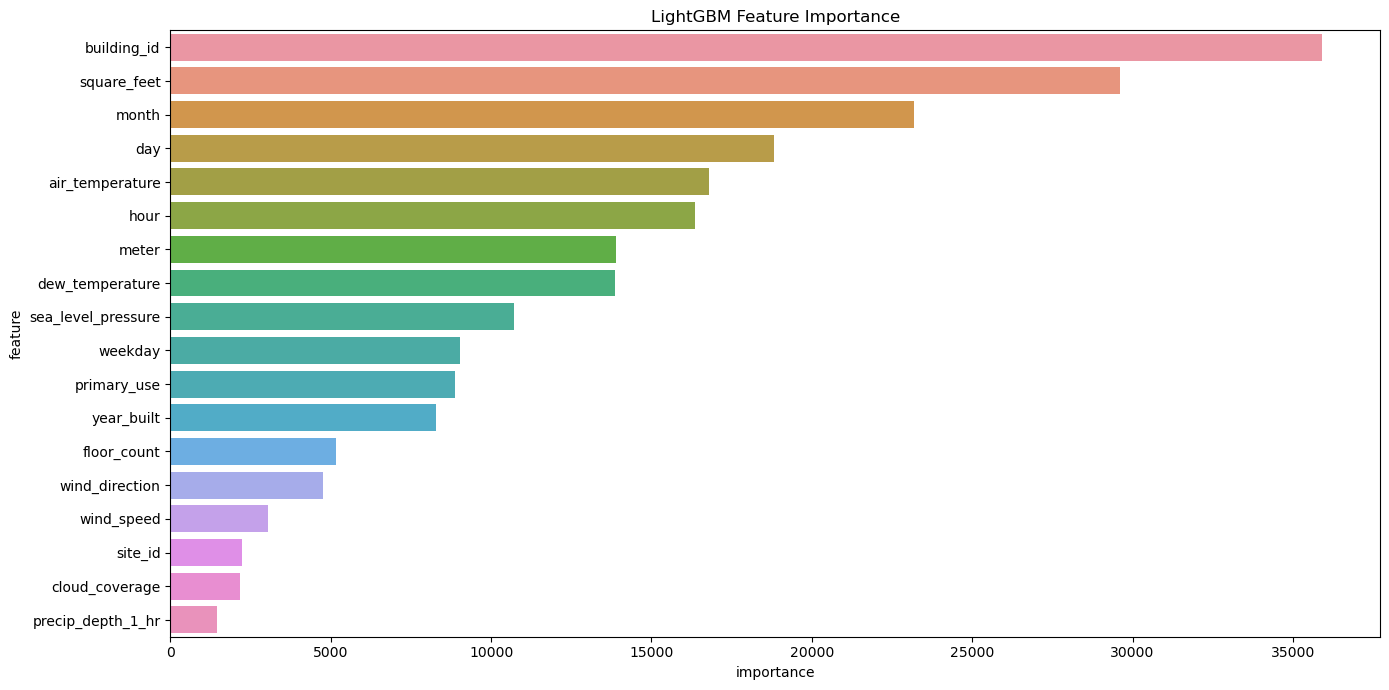

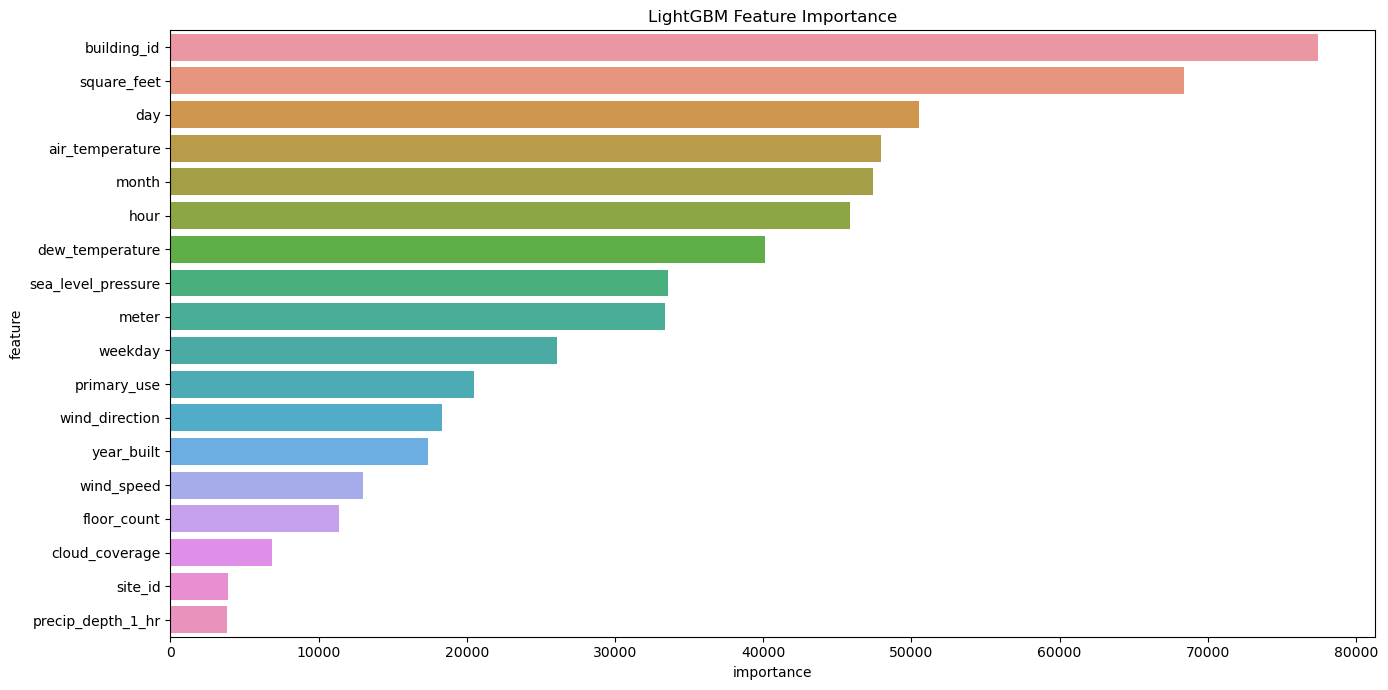

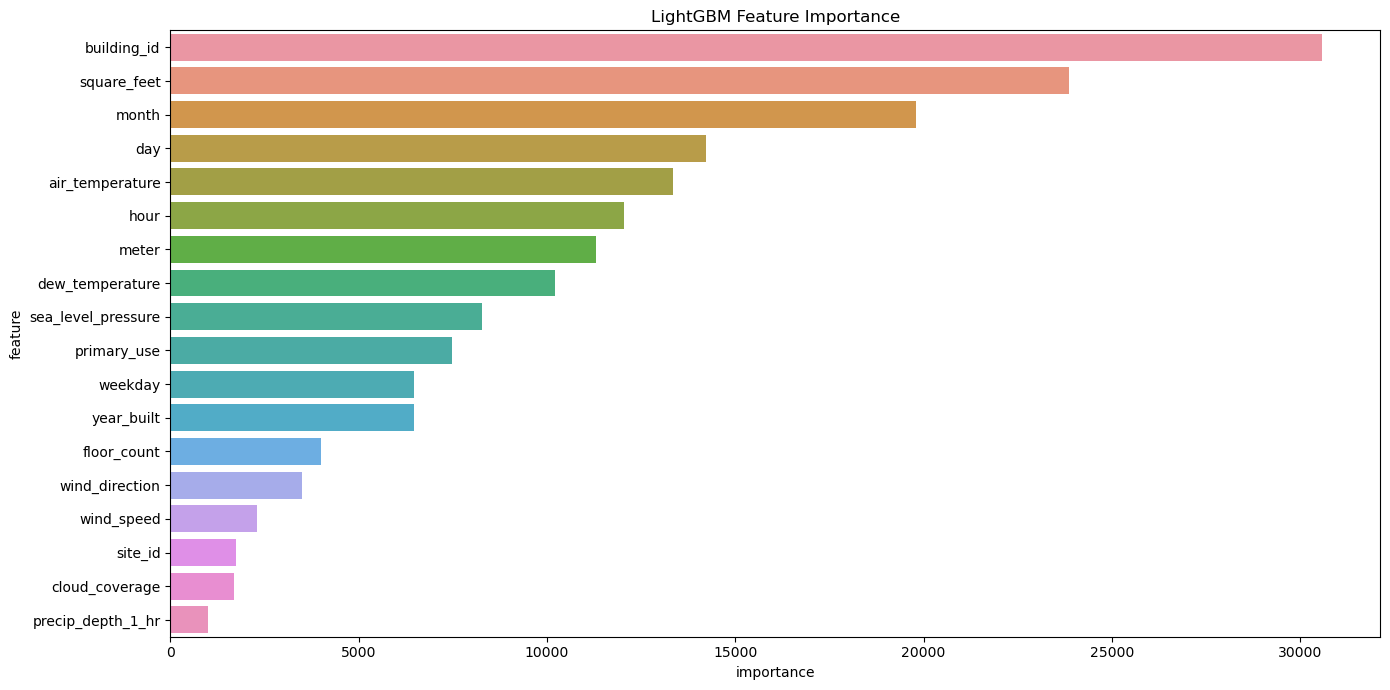

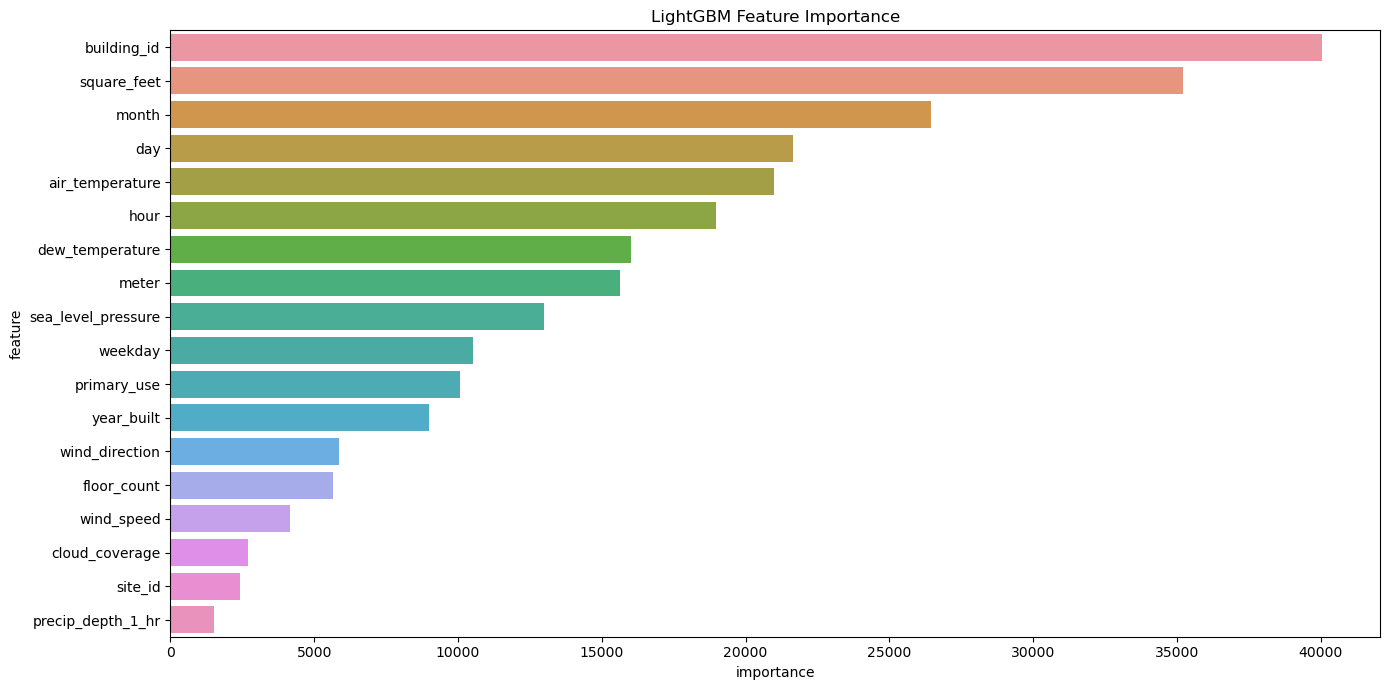

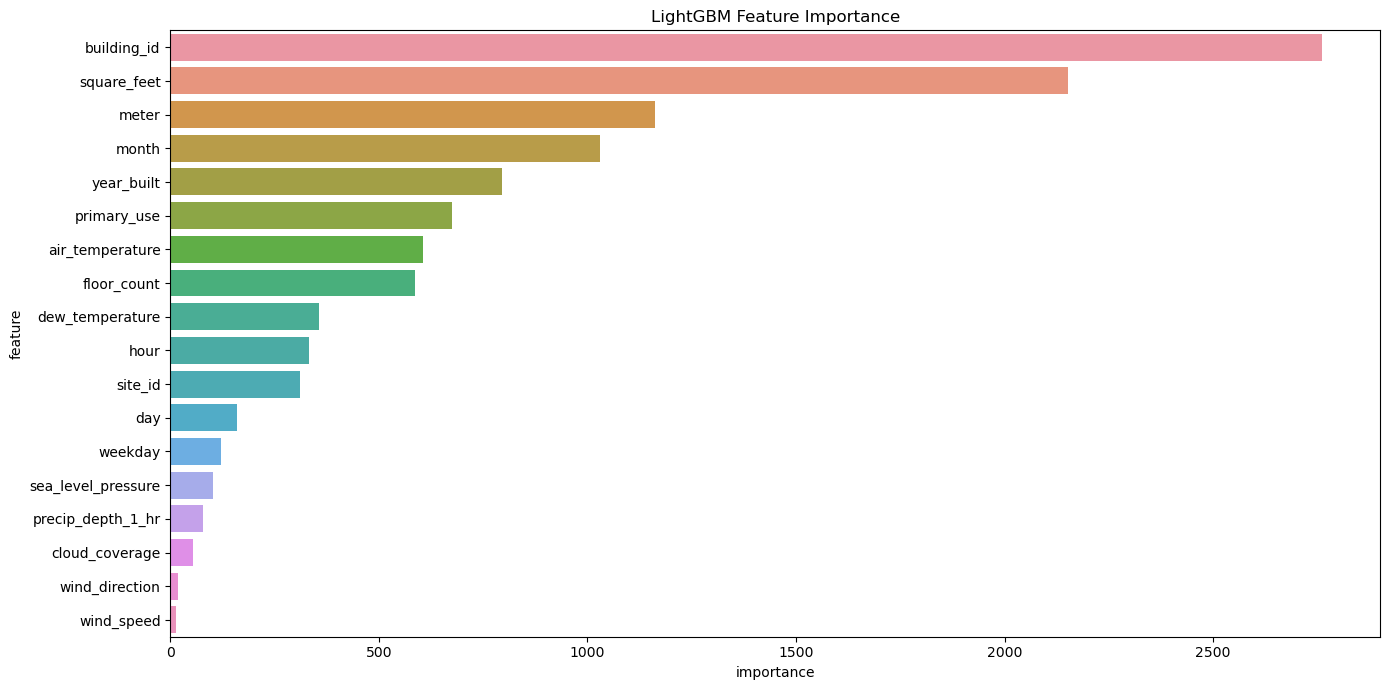

In [32]:
for model in models:
    df_fimp = pd.DataFrame()
    df_fimp["feature"] = d_training.feature_name
    df_fimp["importance"] = model.feature_importance()
    plt.figure(figsize=(14, 7))
    sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
    plt.title("LightGBM Feature Importance")
    plt.tight_layout()

In [33]:
# using average of each individual model to predict over test dataset
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(X_test, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(X_test, num_iteration=model.best_iteration)) / len(models)

In [52]:
res = np.append(results[:-1], results[-2:])

In [81]:
sample_submission = pd.read_csv('sample_submission.csv')

In [54]:
res = res[:-1]

In [74]:
# loading sample submission and inputting predictions
lgbm_sub = sample_submission
lgbm_sub["meter_reading"] = res

In [87]:
lgbm_sub.to_csv('lgbm_final_sub.csv', index=False)

## Visualising RMSE

NameError: name 'model_evals' is not defined

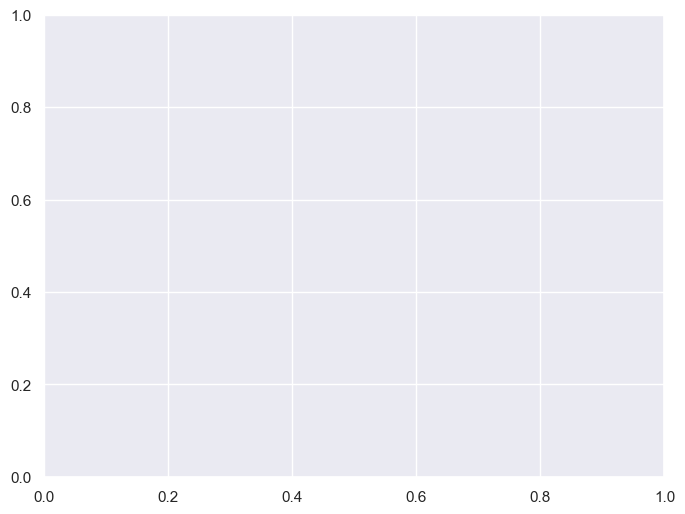

In [145]:
fig, ax = plt.subplots(figsize=(8, 6))
for model_index,model in enumerate(model_evals):
    values=list(model['training'].items())[0][1]
    ax.plot(np.arange(len(values)), values, label=f'Model {model_index+1}')

ax.set_xlabel('Boosting Iterations')
ax.set_ylabel('RMSE')
ax.set_title("Visualising Training Set RMSE")
ax.legend()
plt.show()

NameError: name 'model_evals' is not defined

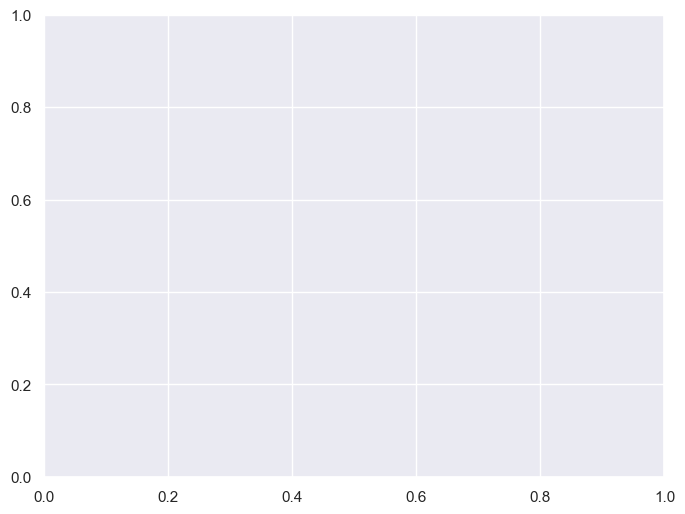

In [146]:
fig, ax = plt.subplots(figsize=(8, 6))
for model_index,model in enumerate(model_evals):
    values=list(model['valid_1'].items())[0][1]
    ax.plot(np.arange(len(values)), values, label=f'Model {model_index+1}')

ax.set_xlabel('Boosting Iterations')
ax.set_ylabel('RMSE')
ax.set_title("Visualising Validation Set RMSE")
ax.legend()
plt.show()

# for model in model_evals:
#     lgb.plot_metric(model, metric='rmse')
#     plt.show()


###  Importing processed data and reshaping it to 3D for next models

In [6]:
import pydot
import graphviz
%matplotlib inline
import json
import os
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection  import train_test_split
import numpy as np
import gc
from scipy.stats import norm 
from scipy import stats, integrate
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras import optimizers
from keras.layers import SimpleRNN
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from keras import regularizers

In [9]:
X = reduce_mem_usage(X)
test = reduce_mem_usage(test)
sample_submission = reduce_mem_usage(sample_submission)

Mem. usage decreased to 559.11 Mb (79.9% reduction)
Mem. usage decreased to 1431.57 Mb (75.0% reduction)
Mem. usage decreased to 198.83 Mb (68.7% reduction)


In [10]:
# Perform train test split on X and y
hyper_X, x_val, hyper_y, y_val = train_test_split(X, y, test_size=0.9, random_state=45, shuffle=False)

# Reshape X_val and y_val for RNN
features_val = x_val.shape[-1]
x_val = x_val.values.reshape((x_val.shape[0], 1, features_val))
y_val = y_val.values.reshape(y_val.shape[0], 1)

# Reshape hyper_X and hyper_y for RNN
features_hyper = hyper_X.shape[-1]
hyper_X = hyper_X.values.reshape((hyper_X.shape[0], 1, features_hyper))
hyper_y = hyper_y.values.reshape(hyper_y.shape[0], 1)

# Reshape X and y for RNN
features_train = X.shape[-1]
X = X.values.reshape((X.shape[0], 1, features_train))
y = y.values.reshape(y.shape[0], 1)

print(X.shape, y.shape, x_val.shape, y_val.shape, hyper_X.shape, hyper_y.shape)


(20216099, 1, 18) (20216099, 1) (18194490, 1, 18) (18194490, 1) (2021609, 1, 18) (2021609, 1)


## RNN

In [7]:
# RNN model builder
def rnn_builder(hp):

  model = Sequential()

  hp_activation_funciton = hp.Choice('activation_function', values=['relu', 'tanh'])
  model.add(SimpleRNN(128,return_sequences=True,
                      input_shape=(X.shape[1], X.shape[2]),
                      activation=hp_activation_funciton, 
                      kernel_regularizer=keras.regularizers.l2(0.01)))
  if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.2))
  model.add(BatchNormalization())
  hp_units = hp.Int('units', min_value=20, max_value=300, step=50)

   # Tune the number of layers.
  for i in range(hp.Int("num_layers", 1, 3)):
      model.add(
          SimpleRNN(
              # Tune number of units separately.
              units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
              activation=hp_activation_funciton,
              return_sequences=True,
              kernel_regularizer=keras.regularizers.l2(0.01)
          )
      )
      if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.2))
      model.add(BatchNormalization())





  model.add(SimpleRNN(hp_units,return_sequences=False,
                      activation=hp_activation_funciton, 
                      kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(BatchNormalization())
  if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.2))
  model.add(Dense(1))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01, 
                                                clipnorm=1.), loss='mae')
  
  return model

In [8]:
# RNN model tuner
tuner = kt.Hyperband(rnn_builder,
                     objective='val_loss',
                     max_epochs=10,
                     directory='my_dir',
                     project_name='rnn_final')

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              restore_best_weights=True, 
                                             mode='min')
# Use the TensorBoard callback.


tensorboard = keras.callbacks.TensorBoard("rnn_logs")

In [ ]:
# search for the optimal hyperparameters for RNN
tuner.search(hyper_X, hyper_y, epochs=50, validation_split=0.2, callbacks=[stop_early, tensorboard], shuffle=False)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the last densely-connected
layer is {best_hps.get('units')}, while the optimal number of nodes for the second connected layer
is {best_hps.get('units_0')}, for the third layer is {best_hps.get('units_1')} and for the fourth
layer is {best_hps.get('units_2')}. The activation function for the hidden layers is {best_hps.get('activation_function')} 
The number of layers is {best_hps.get('num_layers')} and the dropout boolean is {best_hps.get('dropout')}.
""")

In [12]:
# Get the top model
RNN_model = tuner.get_best_models(num_models=1)[0]
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 128)            18816     
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 480)            292320    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 480)           1920      
 hNormalization)                                                 
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 120)               72120     
                                                                 
 batch_normalization_2 (Batc  (None, 120)              4

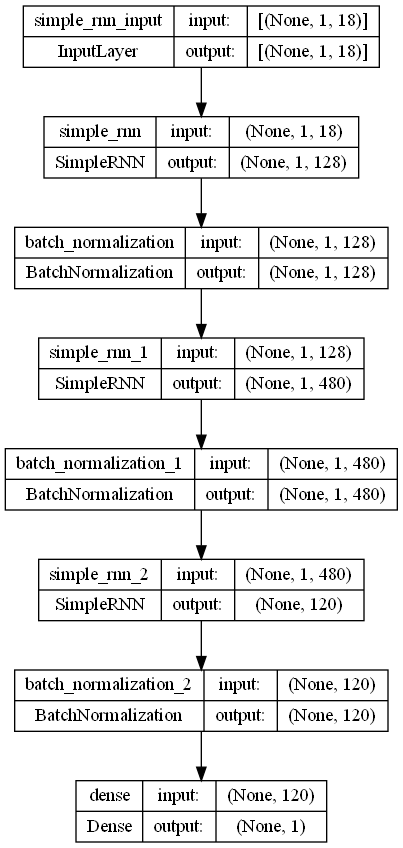

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(RNN_model, to_file='RNN_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Retraining the model using optimal hyperparameters on the entire training set
RNN_model = rnn_builder(tuner.get_best_hyperparameters(1)[0])
stop_early2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,
                                               restore_best_weights=True, 
                                              mode='min')
checkpoint_rnn = tf.keras.callbacks.ModelCheckpoint("RNN_model.h5")
RNN_model.fit(x=X, y=y, epochs=2, callbacks=[stop_early2, checkpoint_rnn])

In [17]:
RNN_model.save('RNN_model.h5')

## GRU

In [126]:
def gru_builder(hp):

  model = Sequential()

  hp_activation_funciton = hp.Choice('activation_function', values=['relu', 'tanh'])
  model.add(GRU(128,return_sequences=True,
                      input_shape=(X.shape[1], X.shape[2]),
                      activation=hp_activation_funciton, 
                      kernel_regularizer=keras.regularizers.l2(0.01)))
  if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.2))
  model.add(BatchNormalization())
  hp_units = hp.Int('units', min_value=20, max_value=300, step=50)

   # Tune the number of layers.
  for i in range(hp.Int("num_layers", 1, 3)):
      model.add(
          GRU(
              # Tune number of units separately.
              units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
              activation=hp_activation_funciton,
              return_sequences=True,
              kernel_regularizer=keras.regularizers.l2(0.01)
          )
      )
      if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.2))
      model.add(BatchNormalization())





  model.add(GRU(hp_units,return_sequences=False,
                      activation=hp_activation_funciton, 
                      kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(BatchNormalization())
  if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.2))
  model.add(Dense(1))
  # hp_learning_rate = hp.Choice('learning_rate', values=[.0001, .1, .01])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01, 
                                                clipnorm=1.), loss='mae')
  
  return model

In [127]:
tuner2 = kt.Hyperband(gru_builder,
                     objective='val_loss',
                     max_epochs=10,
                     directory='my_dir',
                     project_name='gru_final')
tensorboard2 = keras.callbacks.TensorBoard("gru_logs")

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              restore_best_weights=True, 
                                             mode='min')
tuner2.search(hyper_X, hyper_y, epochs=50, validation_split=0.2, callbacks=[stop_early, tensorboard2], shuffle=False)

# Get the optimal hyperparameters
best_hps2=tuner2.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the last densely-connected
layer is {best_hps2.get('units')}, while the optimal number of nodes for the second connected layer
is {best_hps2.get('units_0')}, for the third layer is {best_hps2.get('units_1')} and for the fourth
layer is {best_hps2.get('units_2')}. The activation function for the hidden layers is {best_hps2.get('activation_function')} 
The number of layers is {best_hps2.get('num_layers')} and the dropout boolean is {best_hps2.get('dropout')}.
""")

In [136]:
# Get the top model
GRU_model = tuner2.get_best_models(num_models=1)[0]
GRU_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 128)            56832     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 batch_normalization (BatchN  (None, 1, 128)           512       
 ormalization)                                                   
                                                                 
 gru_1 (GRU)                 (None, 1, 416)            681408    
                                                                 
 dropout_1 (Dropout)         (None, 1, 416)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 416)           1664      
 hNormalization)                                        

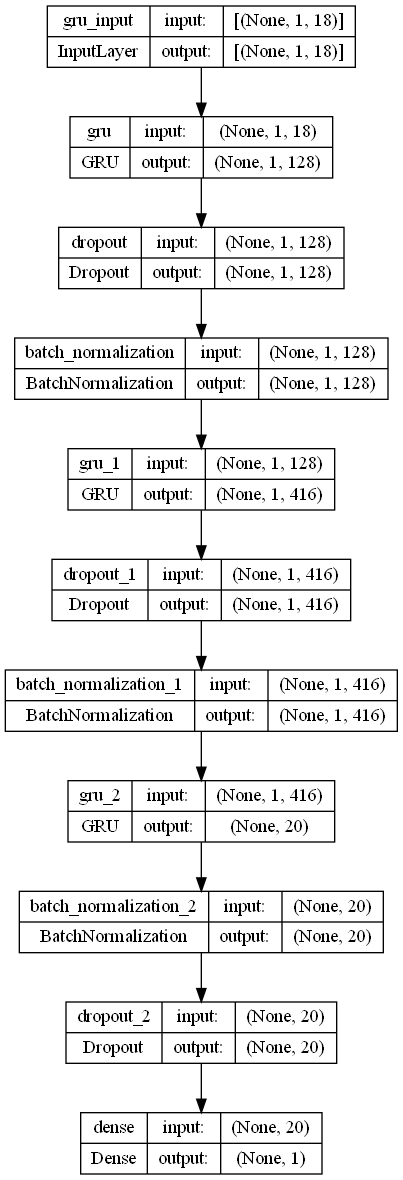

In [137]:
plot_model(GRU_model, to_file='GRU_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Retraining the model using optimal hyperparameters
GRU_model = gru_builder(tuner2.get_best_hyperparameters(1)[0])
checkpoint_gru = tf.keras.callbacks.ModelCheckpoint("GRU_model.h5")
stop_early2 = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,
                                               restore_best_weights=True, 
                                              mode='min')
GRU_model.fit(x=X, y=y, epochs=500, callbacks=[stop_early2, checkpoint_gru])

In [ ]:
GRU_model.save('GRU_model.h5')

## LSTM

In [138]:
#LSTM model builder
def lstm_builder(hp):

  model = Sequential()

  hp_activation_funciton = hp.Choice('activation_function', values=['relu', 'tanh'])
  model.add(LSTM(128,return_sequences=True,
                      input_shape=(X.shape[1], X.shape[2]),
                      activation=hp_activation_funciton, 
                      kernel_regularizer=keras.regularizers.l2(0.01)))
  if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.2))
  model.add(BatchNormalization())
  hp_units = hp.Int('units', min_value=20, max_value=300, step=50)

   # Tune the number of layers.
  for i in range(hp.Int("num_layers", 1, 3)):
      model.add(
          LSTM(
              # Tune number of units separately.
              units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
              activation=hp_activation_funciton,
              return_sequences=True,
              kernel_regularizer=keras.regularizers.l2(0.01)
          )
      )
      if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.2))
      model.add(BatchNormalization())





  model.add(LSTM(hp_units,return_sequences=False,
                      activation=hp_activation_funciton, 
                      kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(BatchNormalization())
  if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.2))
  model.add(Dense(1))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=.01, 
                                                clipnorm=1.), loss='mae')
  
  return model

In [139]:
# LSTM model tuner
tuner3 = kt.Hyperband(lstm_builder,
                     objective='val_loss',
                     max_epochs=10,
                     directory='my_dir',
                     project_name='lstm_final')

In [140]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1,
                                              restore_best_weights=True, 
                                             mode='min')
tensorboard = keras.callbacks.TensorBoard("lstm_logs")

In [141]:
tuner3.search_space_summary()

Search space summary
Default search space size: 5
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 300, 'step': 50, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


In [ ]:
# search for the optimal hyperparameters for LSTM
tuner3.search(hyper_X, hyper_y, epochs=10, validation_split=0.2, callbacks=[stop_early, tensorboard], shuffle=False)


# Get the optimal hyperparameters
best_hps3=tuner3.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the last densely-connected
layer is {best_hps3.get('units')}, while the optimal number of nodes for the second connected layer
is {best_hps3.get('units_0')}, for the third layer is {best_hps3.get('units_1')} and for the fourth
layer is {best_hps3.get('units_2')}. The activation function for the hidden layers is {best_hps3.get('activation_function')} 
The number of layers is {best_hps3.get('num_layers')} and the dropout boolean is {best_hps3.get('dropout')}.
""")

In [ ]:
# Get the top model
LSTM_model = tuner3.get_best_models(num_models=1)[0]
LSTM_model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(LSTM_model, to_file='LSTM_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Retraining the model using optimal hyperparameters
LSTM_model = lstm_builder(best_hps3)
checkpoint_lstm = tf.keras.callbacks.ModelCheckpoint("LSTM_model.h5") 
LSTM_model.fit(x=X, y=y, epochs=5,batch_size = 5000, callbacks=[stop_early2, checkpoint_lstm])

In [ ]:
LSTM_model.save('LSTM_model.h5')

## Results & Analysis with Tensorboard

In [11]:
# Converting test dataset to be in the correct format
test_features = test.shape[-1]
tests = test.values
# reshape input to be 3D [samples, timesteps, features]
tests = tests.reshape((tests.shape[0], 1, test_features))

In [12]:
rnn = keras.models.load_model(r'/RNN_model.h5')
lstm = keras.models.load_model(r'/LSTM_model.h5')
gru = keras.models.load_model(r'/GRU_model.h5')

In [13]:
#Making prediction on test dataset
rnn_pred = test_rnn.predict(tests)
gru_pred = test_gru.predict(tests)
lstm_pred = test_lstm.predict(tests)

1303050/1303050 [==============================] - 1762s 1ms/step


In [18]:
# Saving versions of sample submission to get correct submission format
rnn_sub = sample_submission
gru_sub =  sample_submission
lstm_sub =  sample_submission

In [19]:
# Saving predictions to meter_reading column
rnn_sub["meter_reading"] = rnn_pred
gru_sub["meter_reading"] = gru_pred
lstm_sub["meter_reading"] = lstm_pred

In [21]:
rnn_sub["meter_reading"] = np.expm1(rnn_sub["meter_reading"])
gru_sub["meter_reading"] = np.expm1(gru_sub["meter_reading"])
lstm_sub["meter_reading"] = np.expm1(lstm_sub["meter_reading"])

In [23]:
rnn_sub.to_csv(r'rnnsub_final.csv', index = False)
gru_sub.to_csv(r'grusub_final.csv', index = False)
lstm_sub.to_csv(r'lstmsub_final.csv', index = False)

## Tensorboard Visualizations

Steps to view results on TensorBoard:

Download the logs zip files
Upload them to google drive (or whatever way suitable)
Run the codes below to unzip them and activate the TensorBoards.

In [25]:
#!unzip /content/drive/MyDrive/rnn_logs.zip

In [26]:
#!unzip /content/drive/MyDrive/gru_logs.zip

In [27]:
#!unzip /content/drive/MyDrive/lstm_logs.zip

The code below visualizes results on Tensorboard, it should only be run using Google Colab to avoid Path issues. 

In [64]:
#%load_ext tensorboard

#### Visualizing results for RNN

In [ ]:
#%tensorboard --logdir /content/drive/MyDrive/rnn_logs --port=8000

#### Visualizing results for GRU

In [ ]:
#%tensorboard --logdir /content/drive/MyDrive/gru_logs --port=8080

#### Visualizing results for LSTM

In [ ]:
#%tensorboard --logdir /content/drive/MyDrive/lstm_logs --port=6000